**This notebook loads Argo profile pairs co-located with tropical cyclones and make plots to explore what happens to the upper ocean as the tropical cyclone passes over the ocean. A profile pair comprises one profile before the cyclone, one after. Pairs are co-located using Hu et al, 2021 (using the same code as in Sala et al, 2021).**

Import statements

In [1]:
import pandas as pd
import numpy as np
import numpy.matlib 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import requests

These parameters "need" to be modified

In [2]:
path_fig = '/Users/dgiglio/Downloads/Figures/'
path_file= '/Users/dgiglio/Work/DATA/TC_proj_JS_Salinity2020/bgc_TCpairs/'

These parameters may be modified, if of interest

In [3]:
# set pressure limits for the plots
pres_lim   = [10,200]

min_TCwind = 0 #75 (to keep only pairs co-located with TC that have wind >=75 knots) # if equal to zero, all the pairs are kept
var2use = 'chla' # 'doxy' 

These parameters likely don't need modification for now (unless the input file is created with different pressure levels)

In [4]:
# set pressure axis for the profiles in the input file
pres       = np.arange(10,212,2)

Define a few variables based on input parameters

In [5]:
# file to use (pairs for different ocean properties are stored in different files)

if var2use == 'chla':
    fname = path_file+"HurricaneAdjRawVariableDF_Chla.pkl"
    #fname = "/Users/dgiglio/Work/DATA/TC_proj_JS_Salinity2020/bgc_TCpairs/HurricaneAdjRawVariableDF_qcto2.pkl"
    # set the label for the variable in the input file
    var_lab = 'Chlorophyll a, mg/m3'
elif var2use == 'doxy':
    fname = path_file+"HurricaneAdjRawVariableDF_doxy.pkl"
    var_lab = 'Dissolved Oxygen, micromole/kg'

Here are a few functions that are used later

In [6]:
# **get_profile**
# 
# This function is from [Tucker, Giglio, Scanderbeg 2020](https://www.essoar.org/doi/10.1002/essoar.10504304.1) and gets an Argo float profile of interest.
# 
# profileID format: '5904912_239'.
def get_profile(profileID):
    url = 'https://argovis.colorado.edu/catalog/profiles/{}'.format(profileID)
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    profile = resp.json()
    return profile

# function to parse bgc profiles
def parse_1prof_into_df(profileDict,data_type='core'): #'bgc' to retrieve bgc measurements (including T,S,p yet with no selection and including qc flag)
    df = pd.DataFrame()
    if data_type == 'core':
        profileDf = pd.DataFrame(profileDict['measurements'])
    if data_type == 'bgc' and 'bgcMeas' in profileDict.keys() and 'containsBGC' in profileDict.keys():
        profileDf = pd.DataFrame(profileDict['bgcMeas'])
        profileDf['containsBGC'] = profileDict['containsBGC']
    elif data_type == 'bgc':
        profileDf = pd.DataFrame(profileDict['measurements'])
        
    profileDf['cycle_number'] = profileDict['cycle_number']
    profileDf['profile_id'] = profileDict['_id']
    profileDf['lat'] = profileDict['lat']
    profileDf['lon'] = profileDict['lon']
    profileDf['date'] = profileDict['date']
    profileDf['position_qc'] = profileDict['position_qc']
    df = pd.concat([df, profileDf], sort=False)
    df.head()
    return df

# function to plot the profiles
def make_plot(b,a,b_tag,a_tag,x_tag,b_yax,a_yax,y_tag,y_lim,title_plot):
    b_mask = (b_yax>=min(y_lim)) & (b_yax<=max(y_lim))
    a_mask = (a_yax>=min(y_lim)) & (a_yax<=max(y_lim))
    if 'QC' not in x_tag:
        plt.plot(b[b_mask],b_yax[b_mask],linewidth=3,color='k',marker='*',label=b_tag)
        plt.plot(a[a_mask],a_yax[a_mask],linewidth=3,color='r',marker='*',label=a_tag)
    else:
        plt.plot(b[b_mask],b_yax[b_mask],linewidth=0,color='k',marker='*',label=b_tag)
        plt.plot(a[a_mask],a_yax[a_mask],linewidth=0,color='r',marker='*',label=a_tag)
    plt.title(title_plot,fontsize=font_size)
    plt.gca().set_xlabel(x_tag,fontsize=font_size)
    plt.gca().set_ylabel(y_tag,fontsize=font_size)
    plt.ylim(y_lim)
    plt.gca().invert_yaxis()
    plt.legend(fontsize=font_size*.8)
    
    for tick in plt.gca().xaxis.get_majorticklabels():  # example for xaxis
        tick.set_fontsize(font_size) 
    for tick in plt.gca().yaxis.get_majorticklabels():  # example for xaxis
        tick.set_fontsize(font_size) 

Read in the data and check what is in the dataframe. **Question for Jacopo: which variable is the time difference between the two profiles?**

In [7]:
df = pd.read_pickle(fname)
df.reset_index(drop=True);
df.keys()

Index(['before_pid', 'before_t', 'after_pid', 'after_t', 'angle', 'wind',
       'proj_t', 'sign', 'argo_lat', 'argo_lon', 'HurricaneID', 'profile_dt',
       'hurricane_dt', 'signed_angle', 'adj_before_variable',
       'adj_after_variable', 'raw_before_variable', 'raw_after_variable',
       'standard_signed_angle', 'hurricane_dtd', 'profile_dtd',
       'hurricane_id'],
      dtype='object')

In [8]:
print(np.shape(df))
# df

(30, 22)


Store some of the variables in the dataframe, to use in the notebook.

In [9]:
raw_before_data     = df.raw_before_variable.reset_index(drop=True)
raw_after_data      = df.raw_after_variable.reset_index(drop=True)
raw_before_data_pid = df.before_pid.reset_index(drop=True)
raw_after_data_pid  = df.after_pid.reset_index(drop=True)
HurricaneID         = df.HurricaneID.reset_index(drop=True)
TC_wind             = df.wind.reset_index(drop=True)

**Plot all the pairs, one per figure (including TS and QC flags for each variable). The legend for the temperature plot includes the time of the tropical cyclone and this information can be leveraged to produce relevant maps using the other notebook we discussed. For each pair, also save the difference between the profiles after the TC and the profile before. Let's also save the pressure at which we see a max and the value of the max both before and after the cyclone.**

+++++++++++++++ Tropical Cyclone ID: IO012013 +++++++++++++++


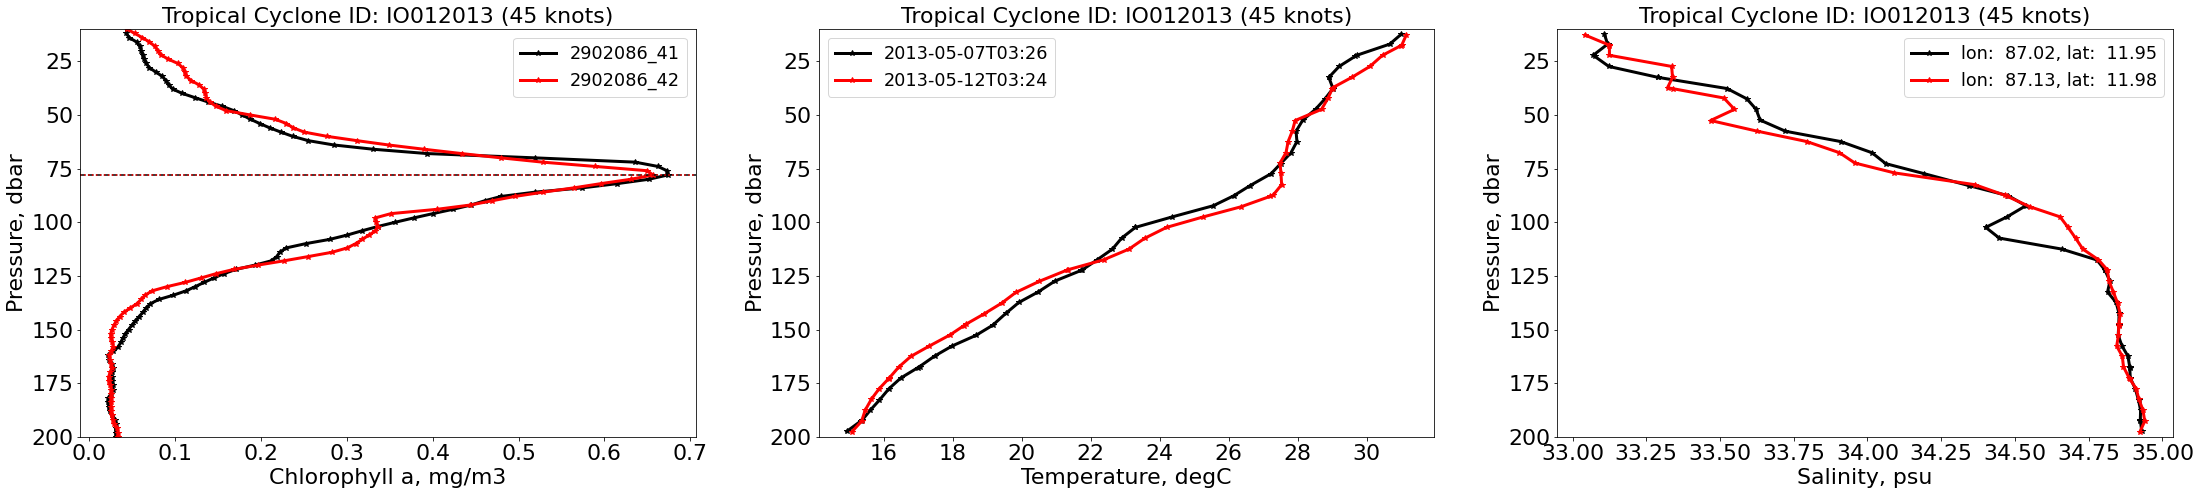

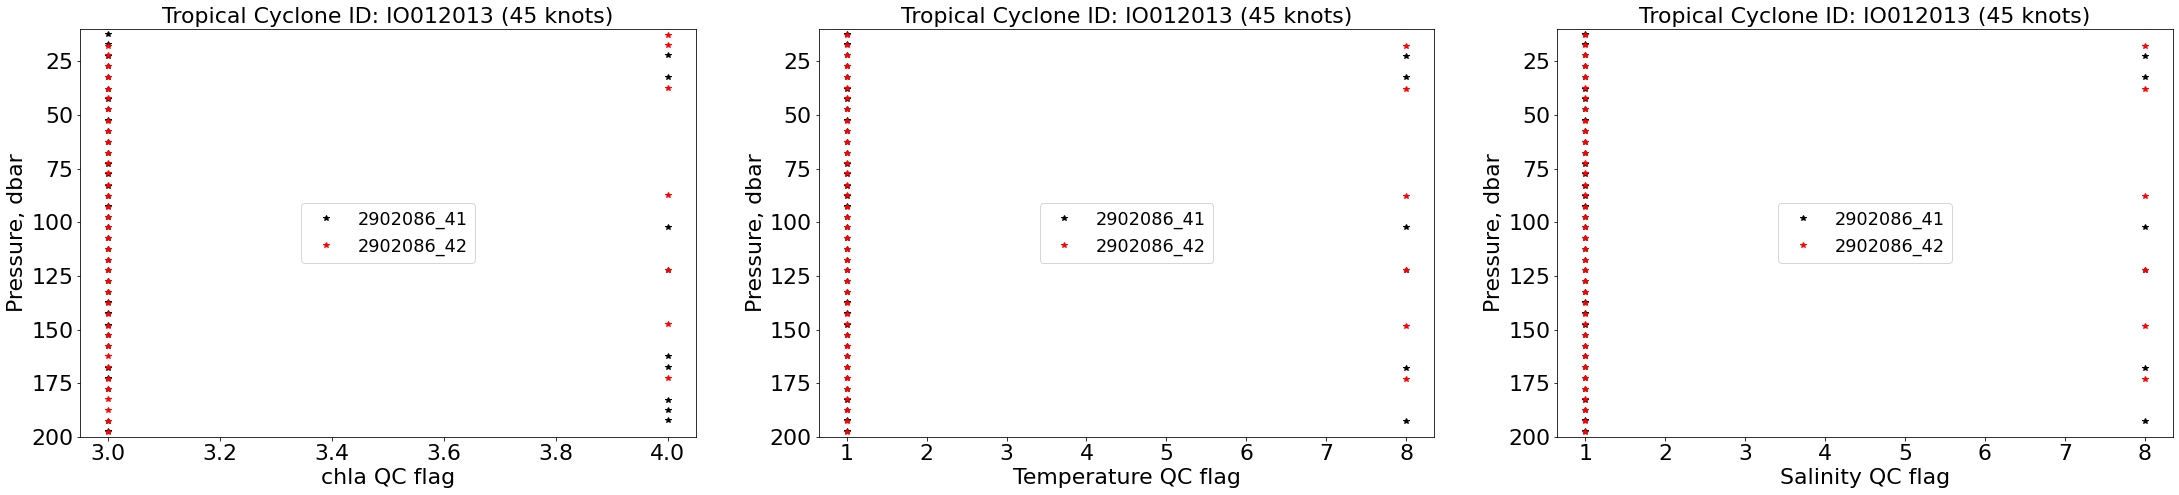

+++++++++++++++ Tropical Cyclone ID: IO022013 +++++++++++++++


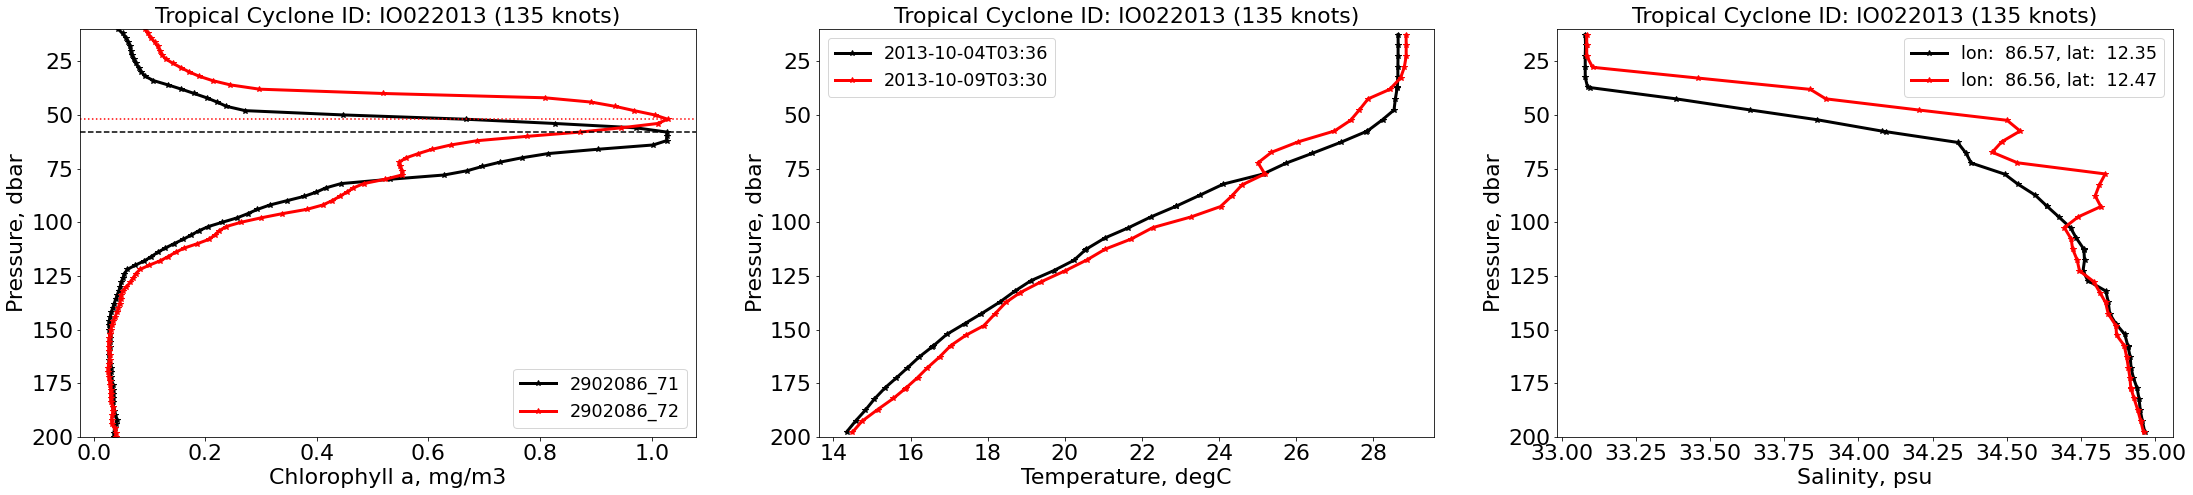

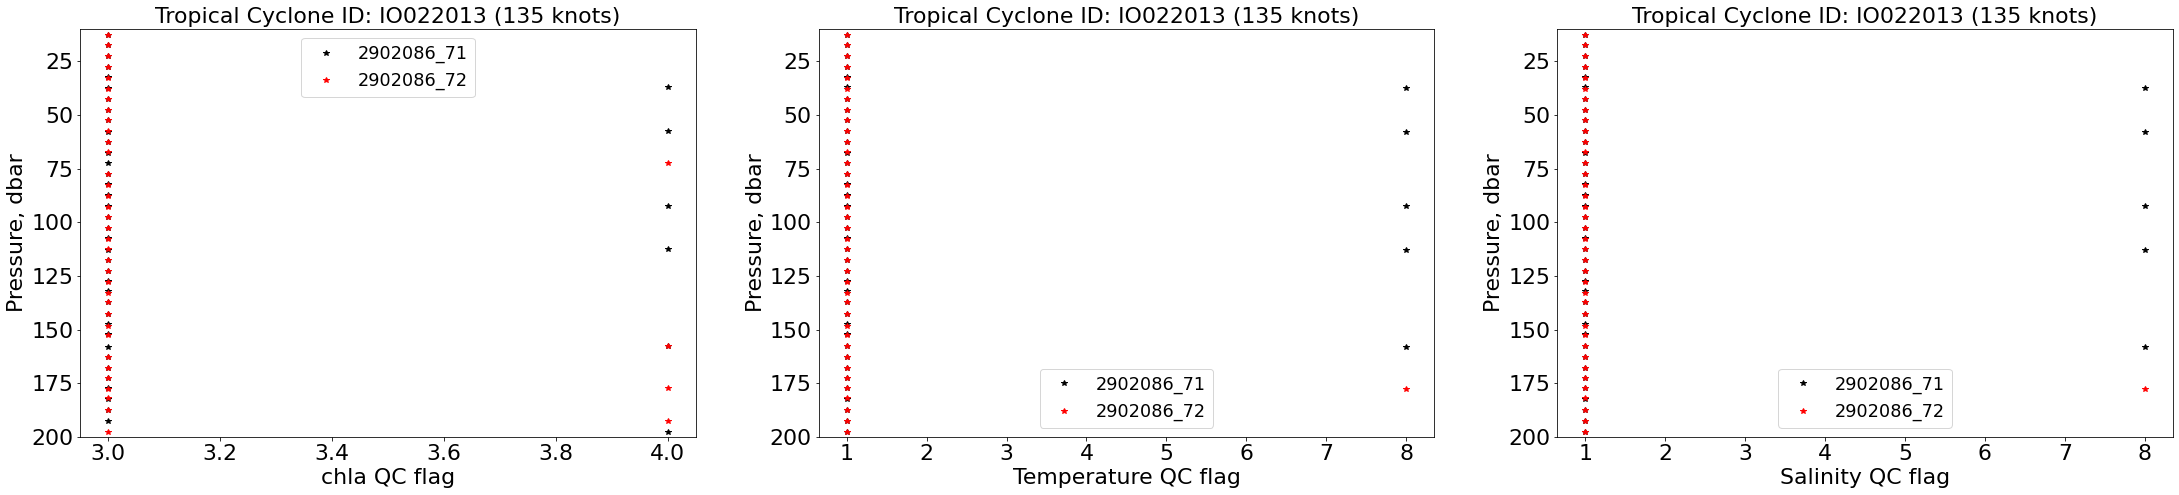

+++++++++++++++ Tropical Cyclone ID: IO022013 +++++++++++++++


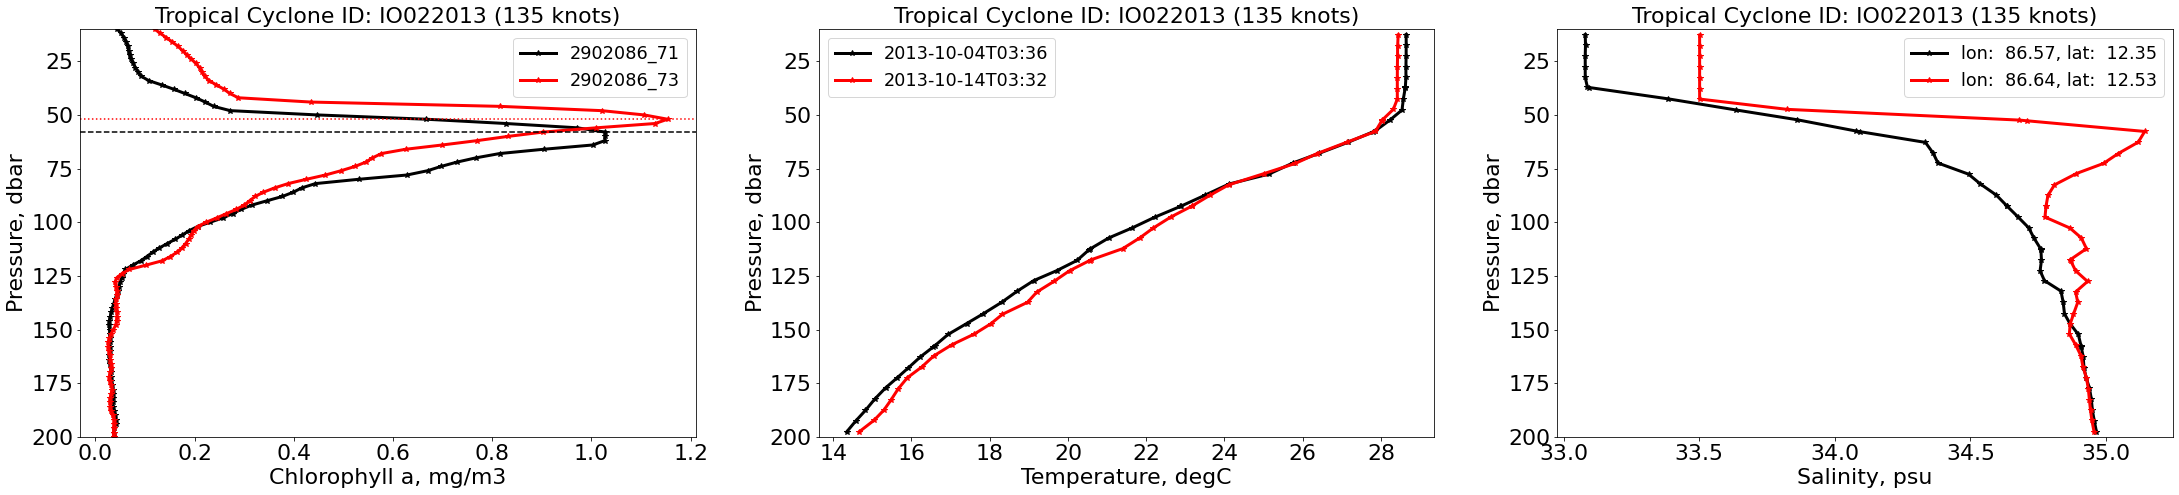

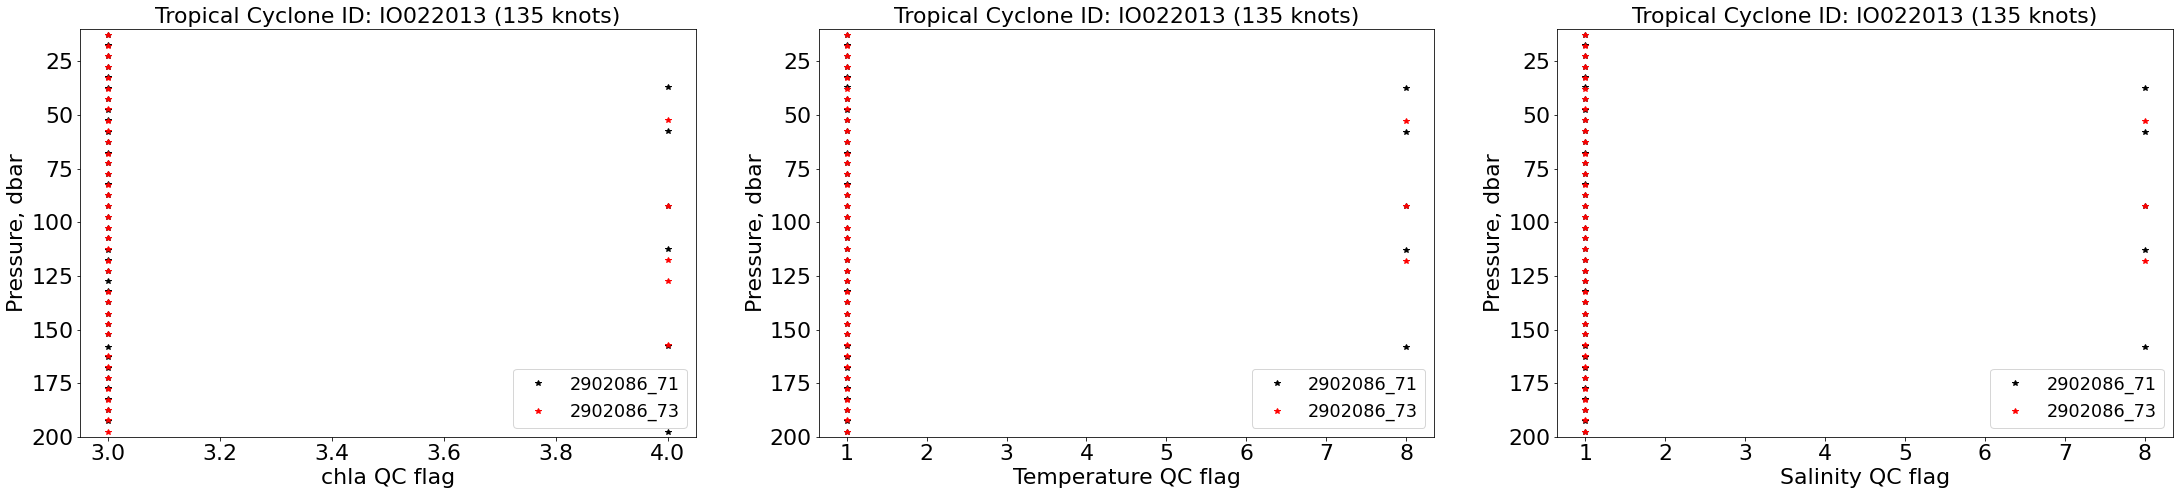

+++++++++++++++ Tropical Cyclone ID: WP302013 +++++++++++++++


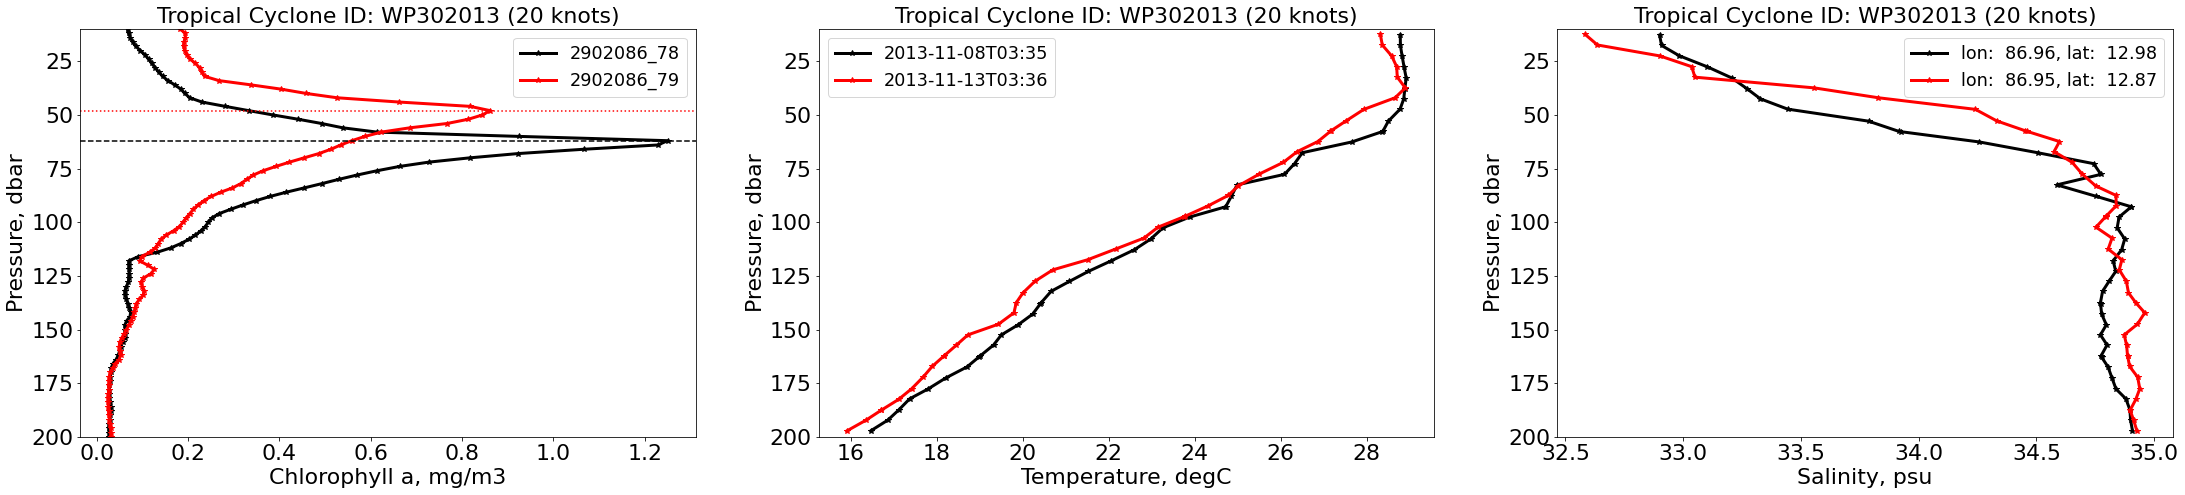

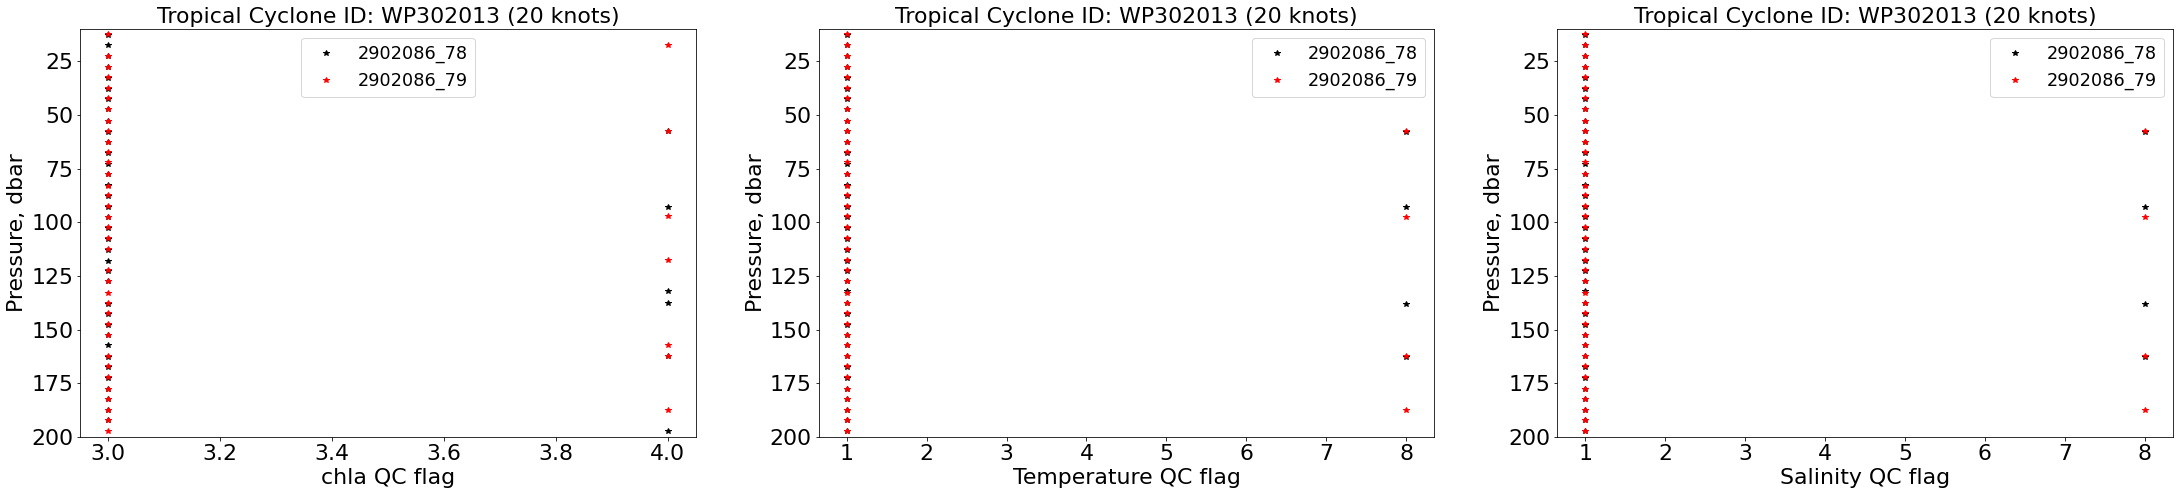

+++++++++++++++ Tropical Cyclone ID: IO042013 +++++++++++++++


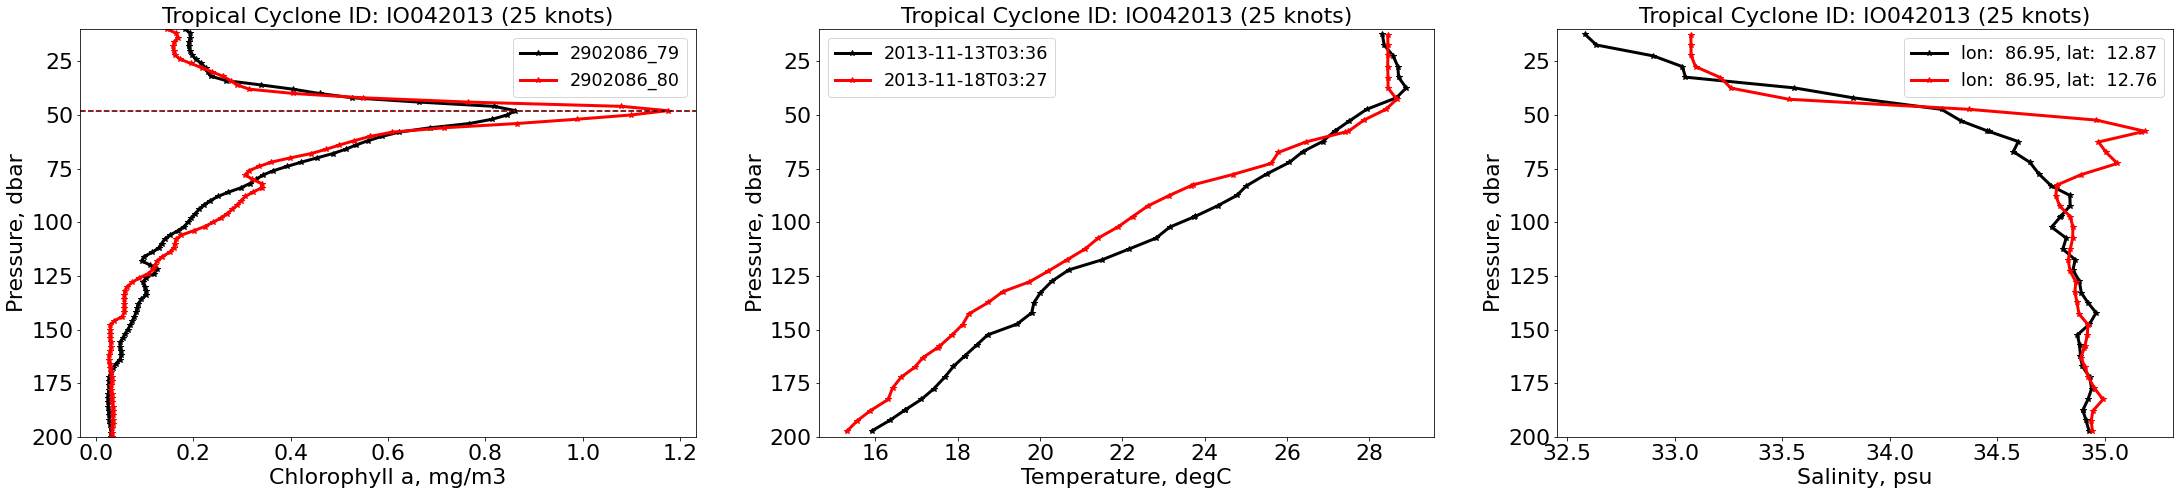

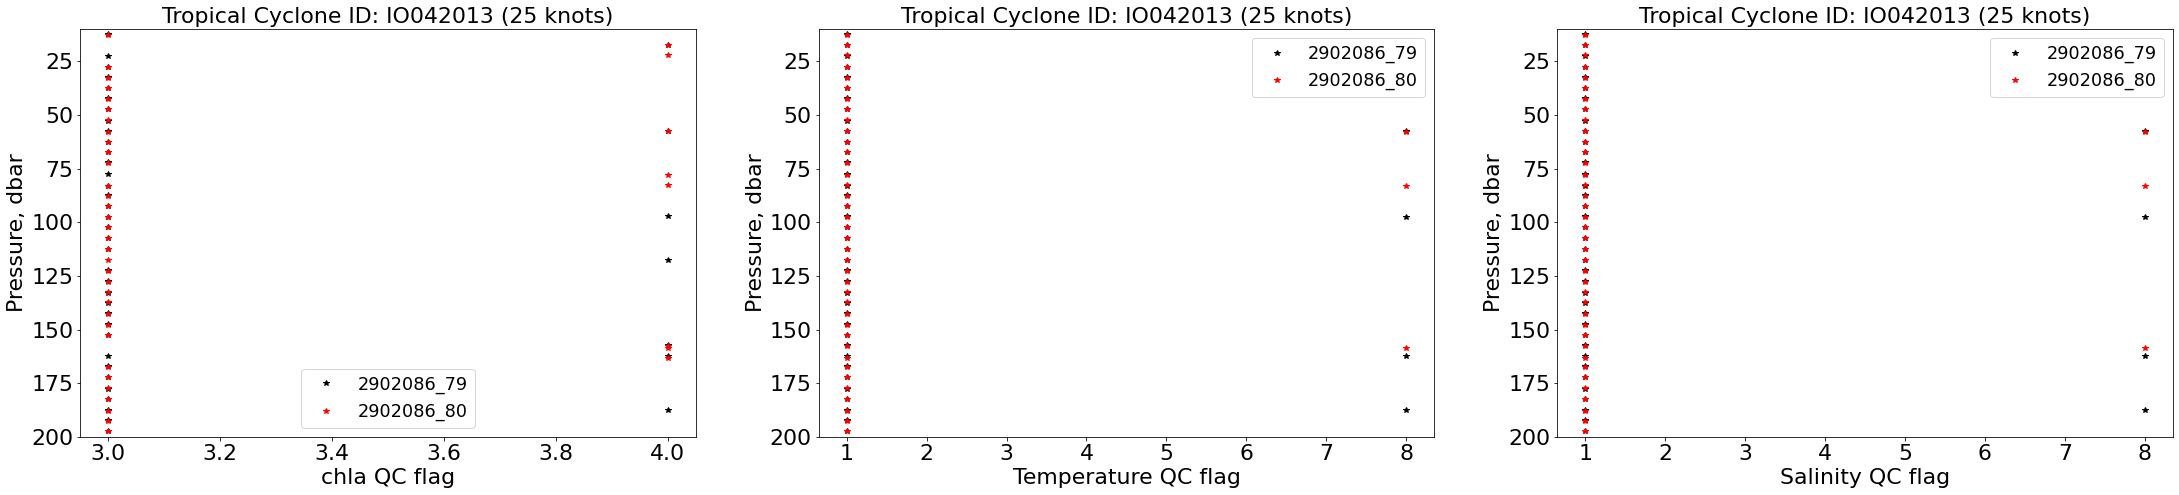

+++++++++++++++ Tropical Cyclone ID: IO042013 +++++++++++++++


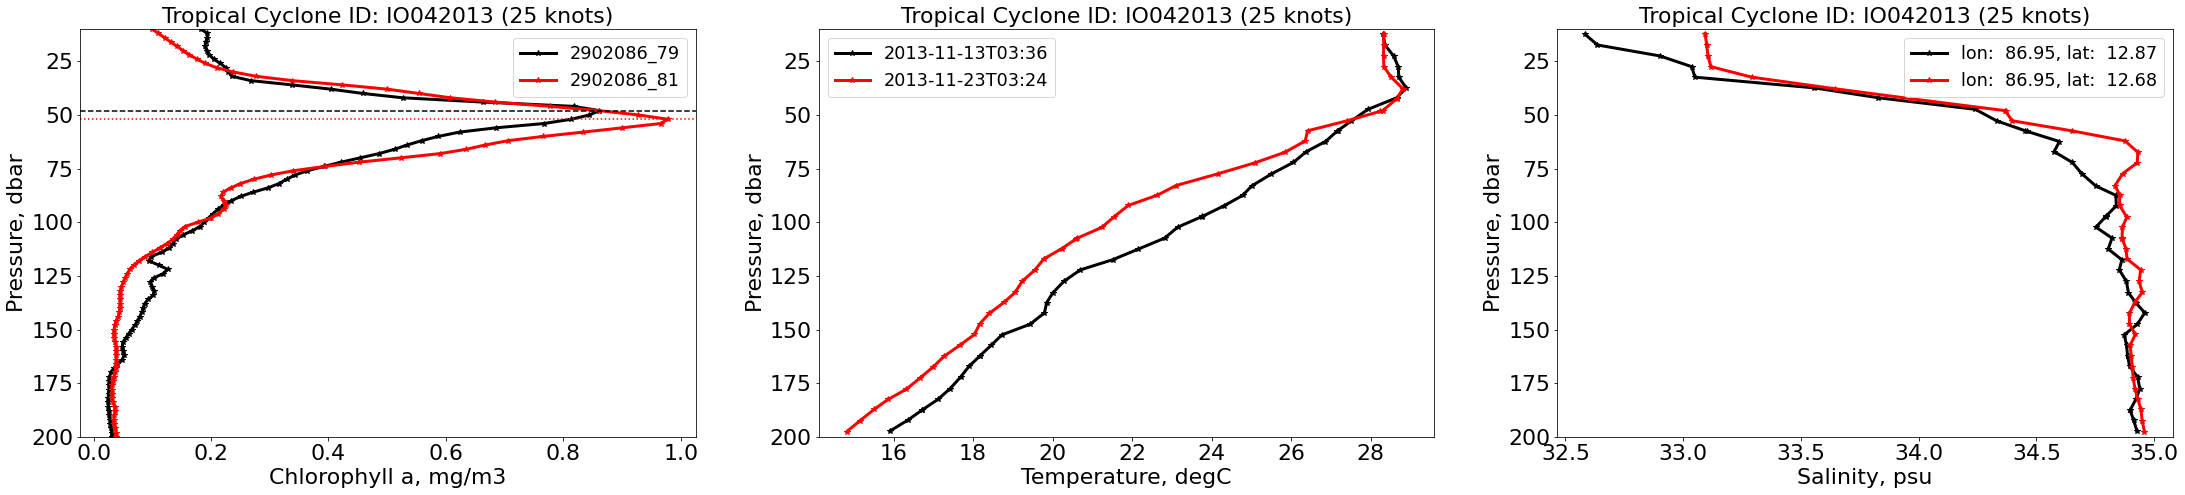

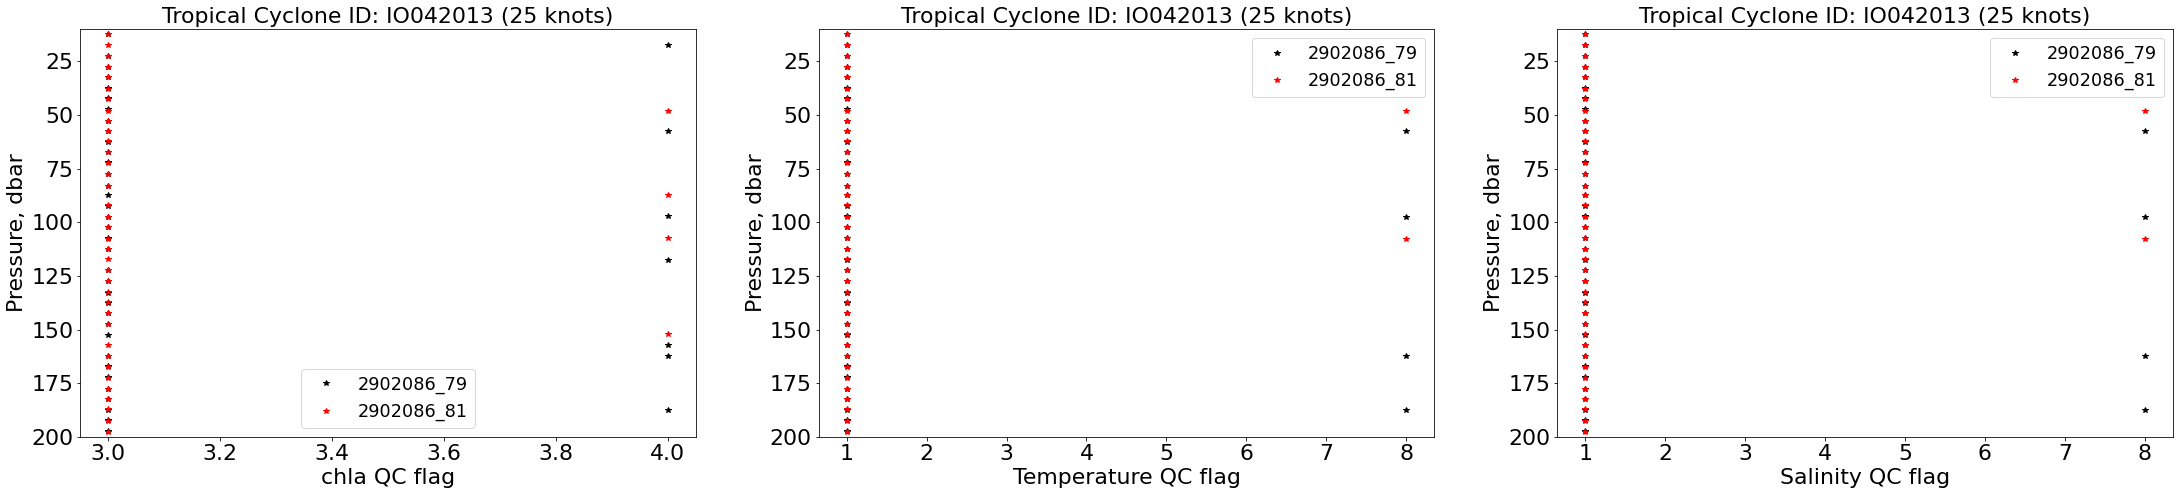

+++++++++++++++ Tropical Cyclone ID: IO052013 +++++++++++++++


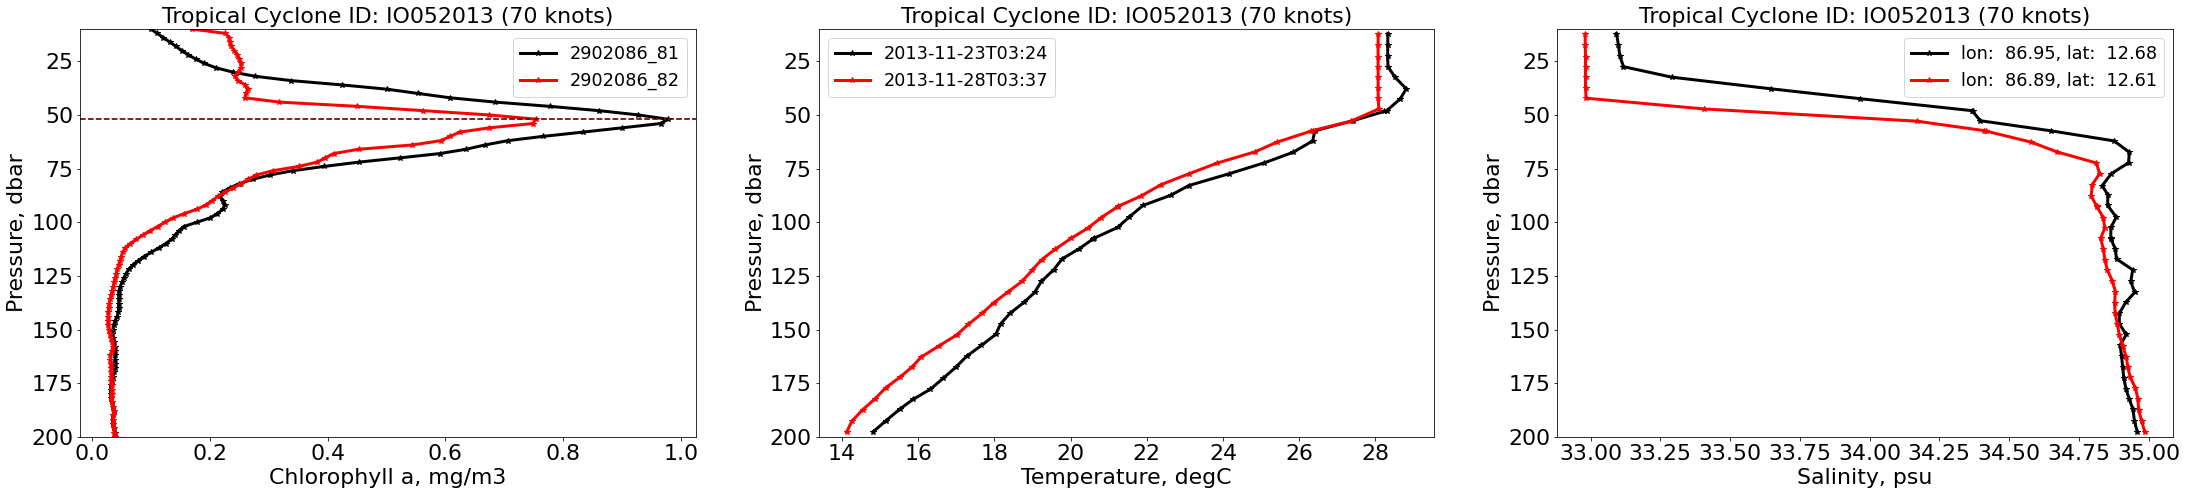

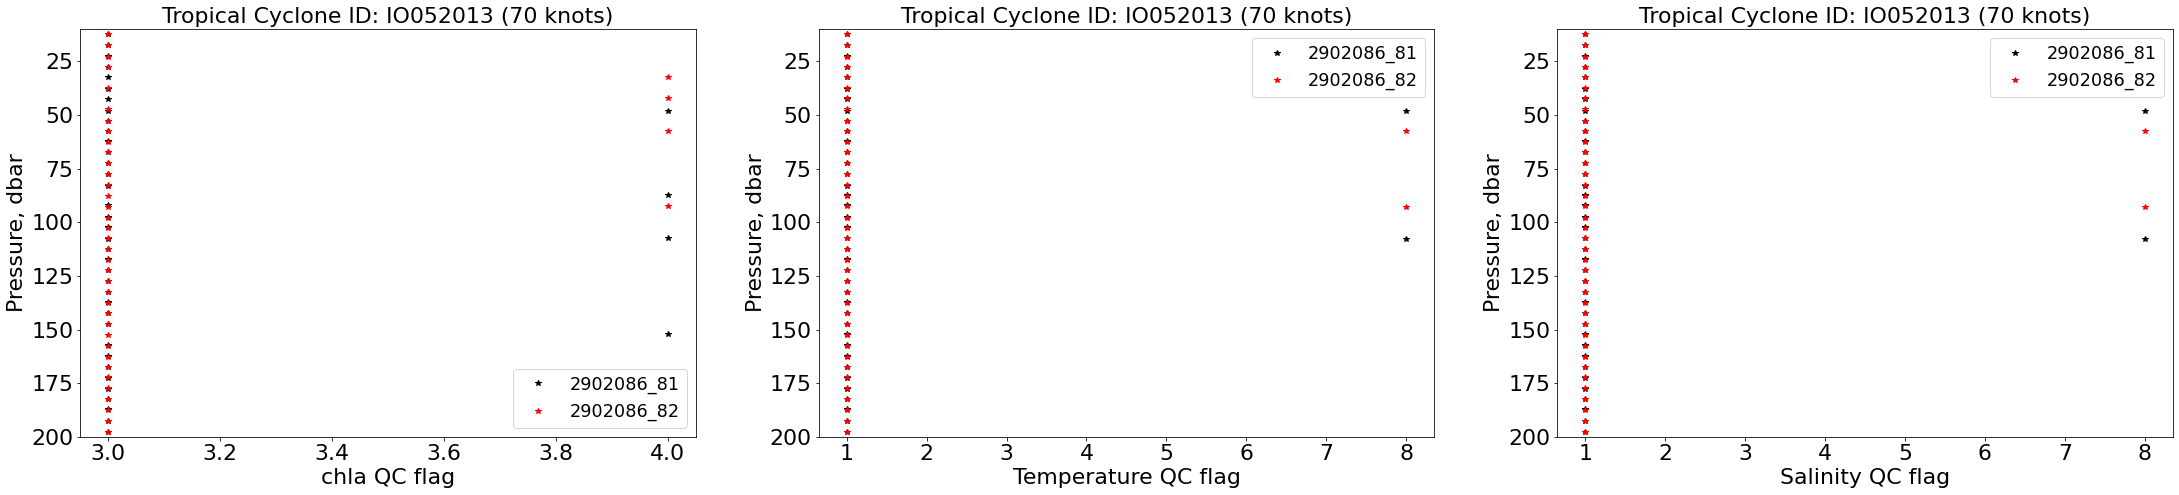

+++++++++++++++ Tropical Cyclone ID: IO052013 +++++++++++++++


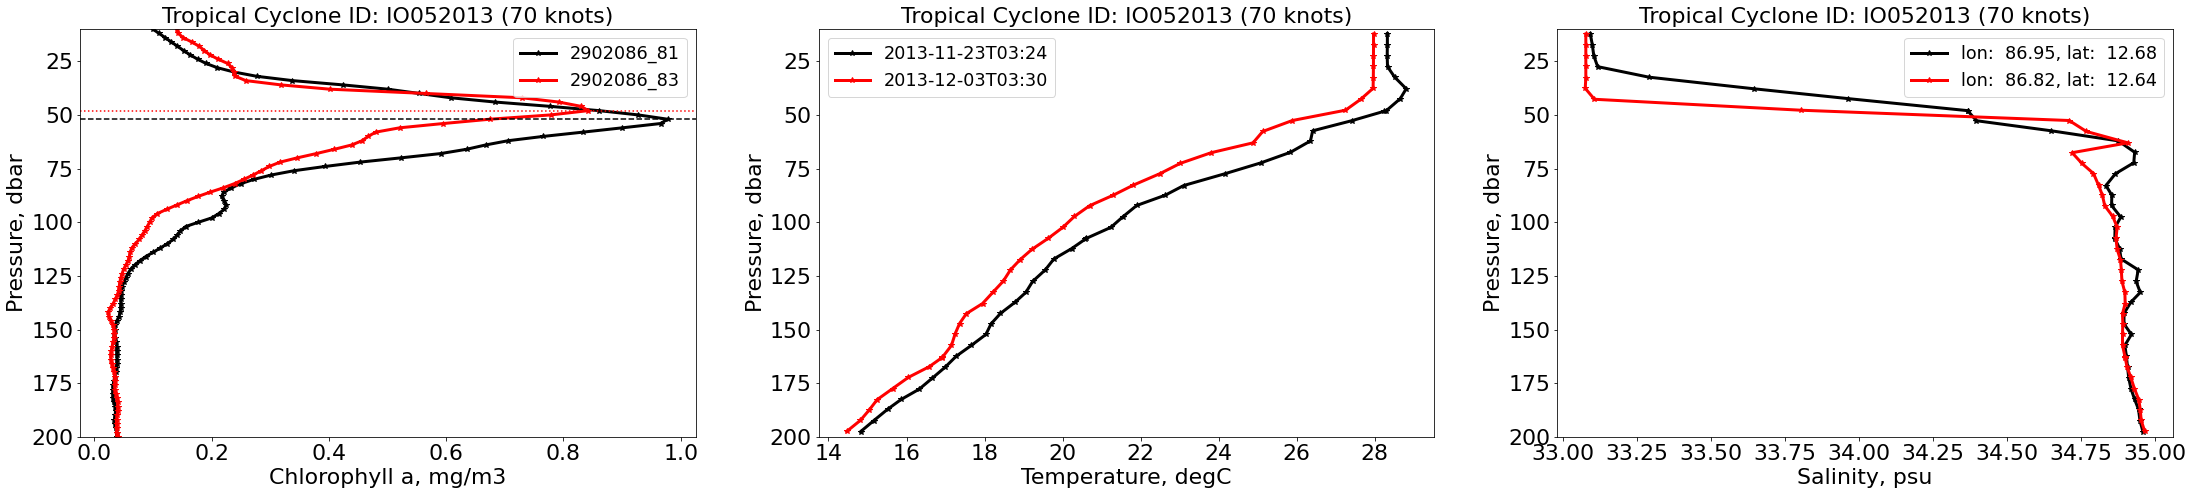

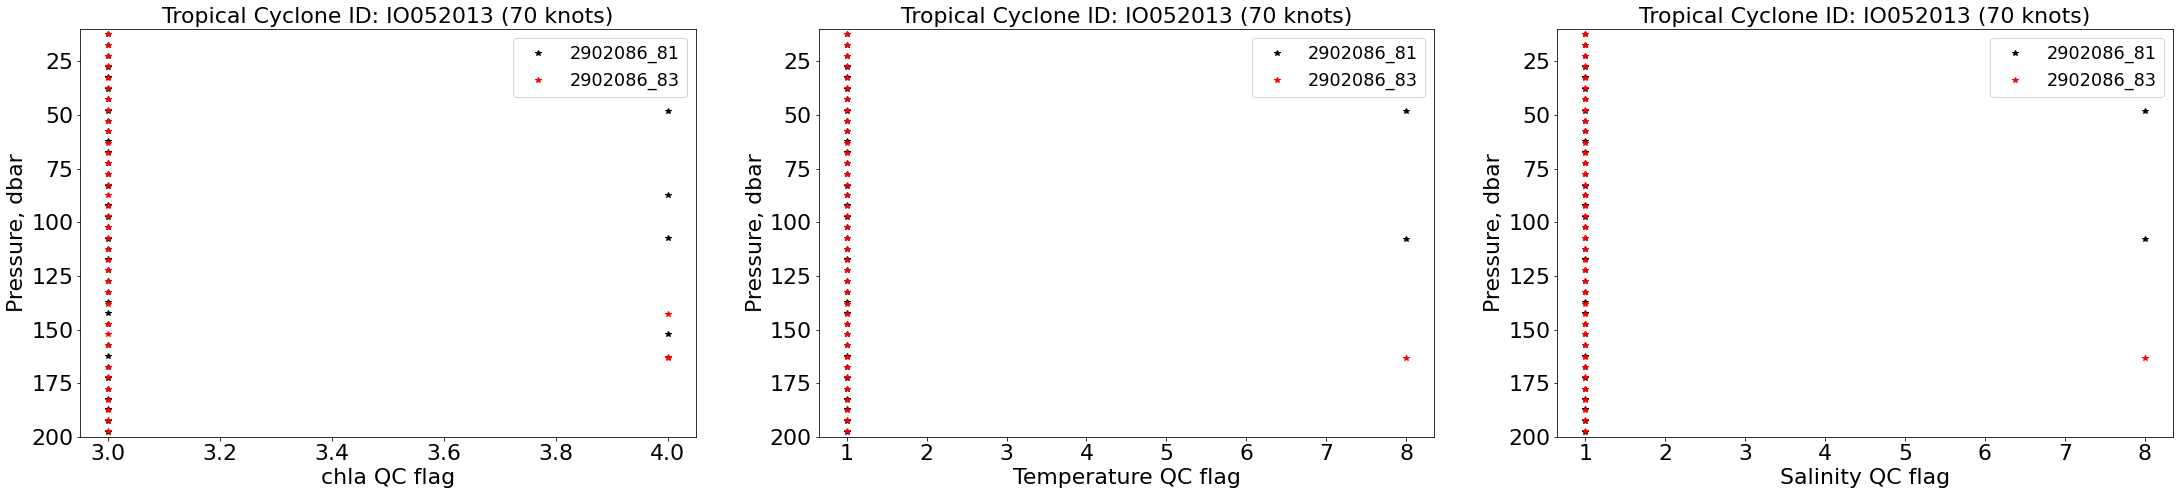

+++++++++++++++ Tropical Cyclone ID: IO062013 +++++++++++++++


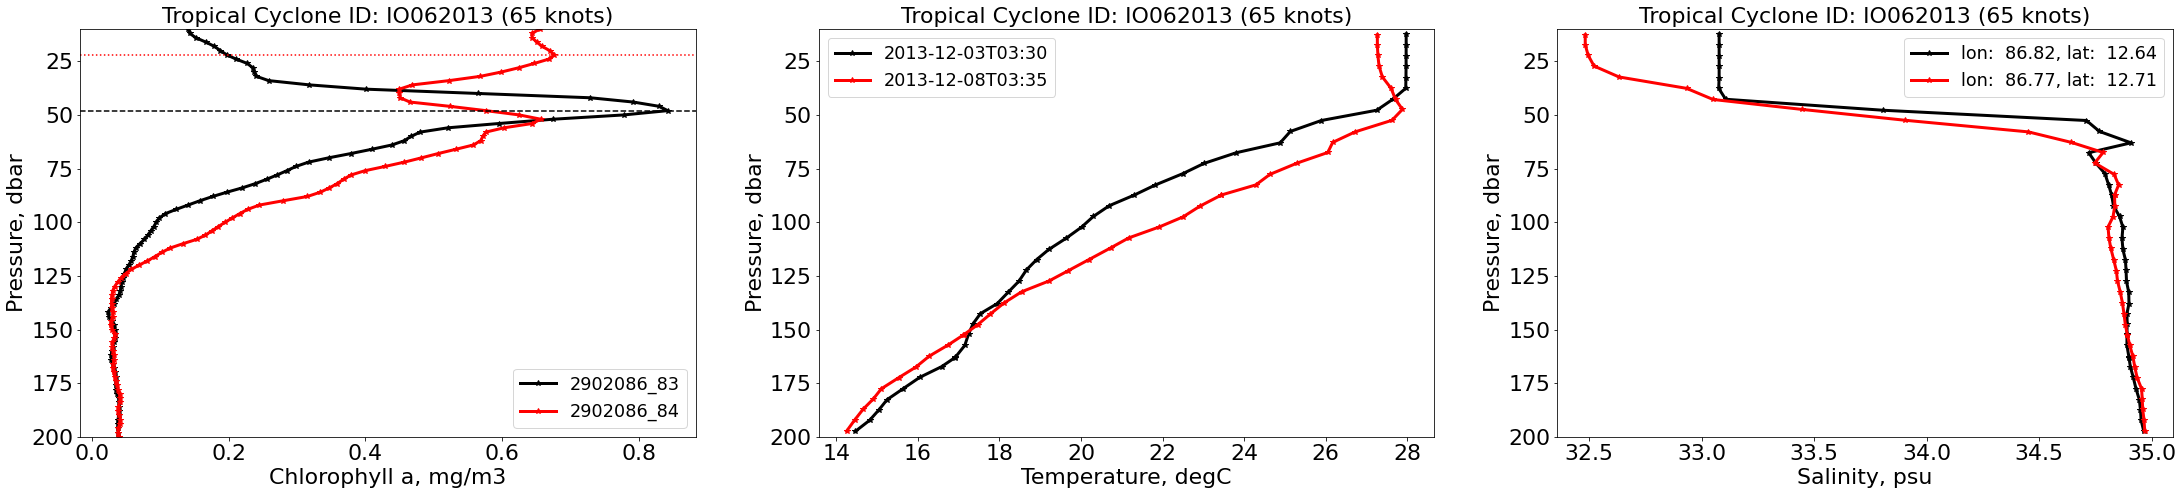

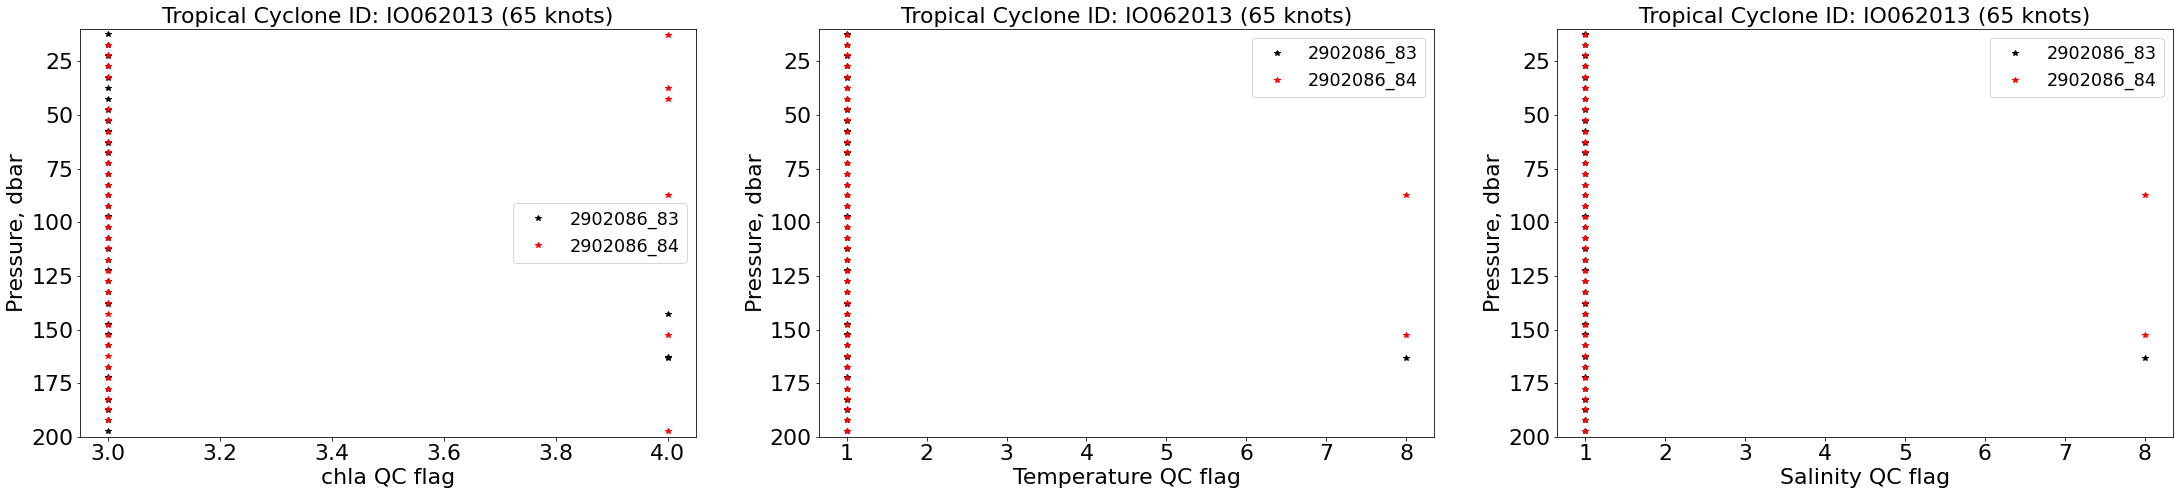

+++++++++++++++ Tropical Cyclone ID: IO062013 +++++++++++++++


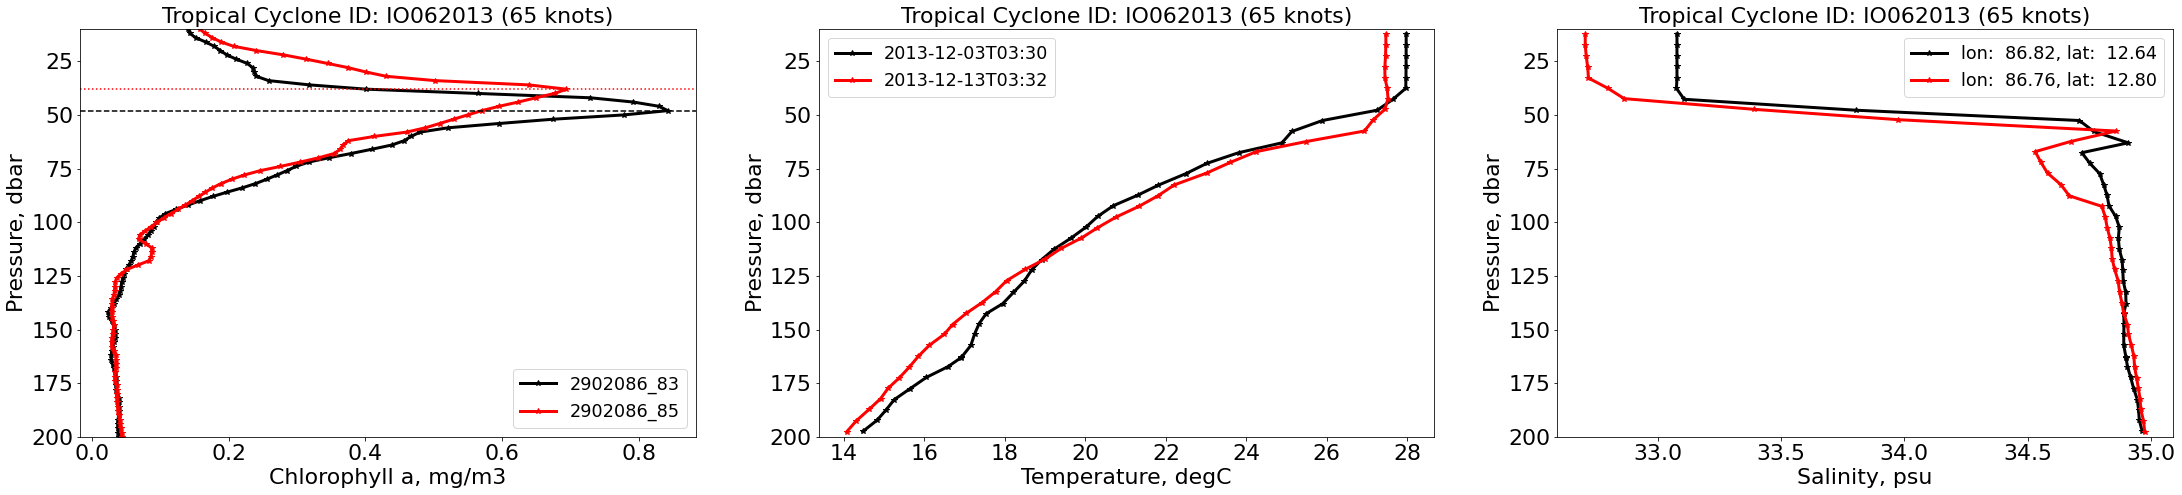

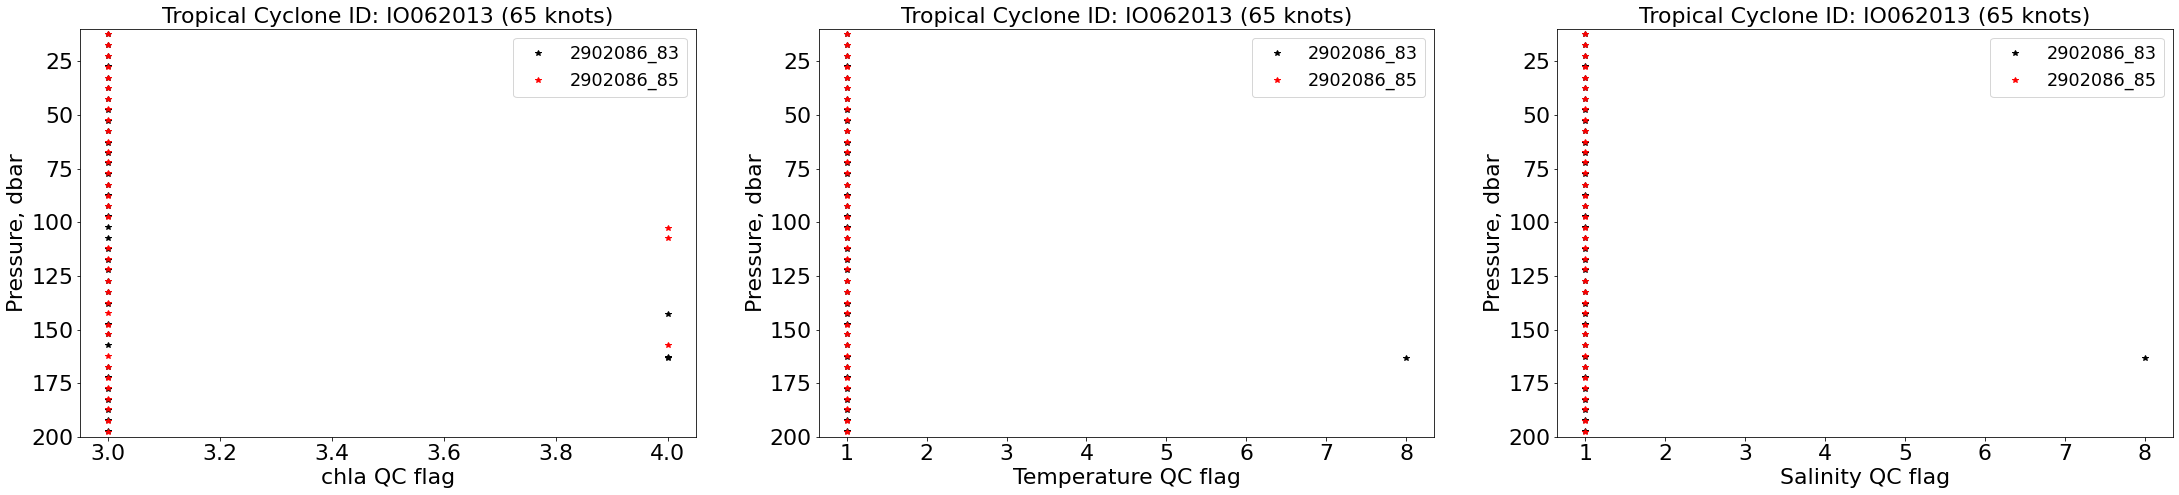

+++++++++++++++ Tropical Cyclone ID: IO062013 +++++++++++++++


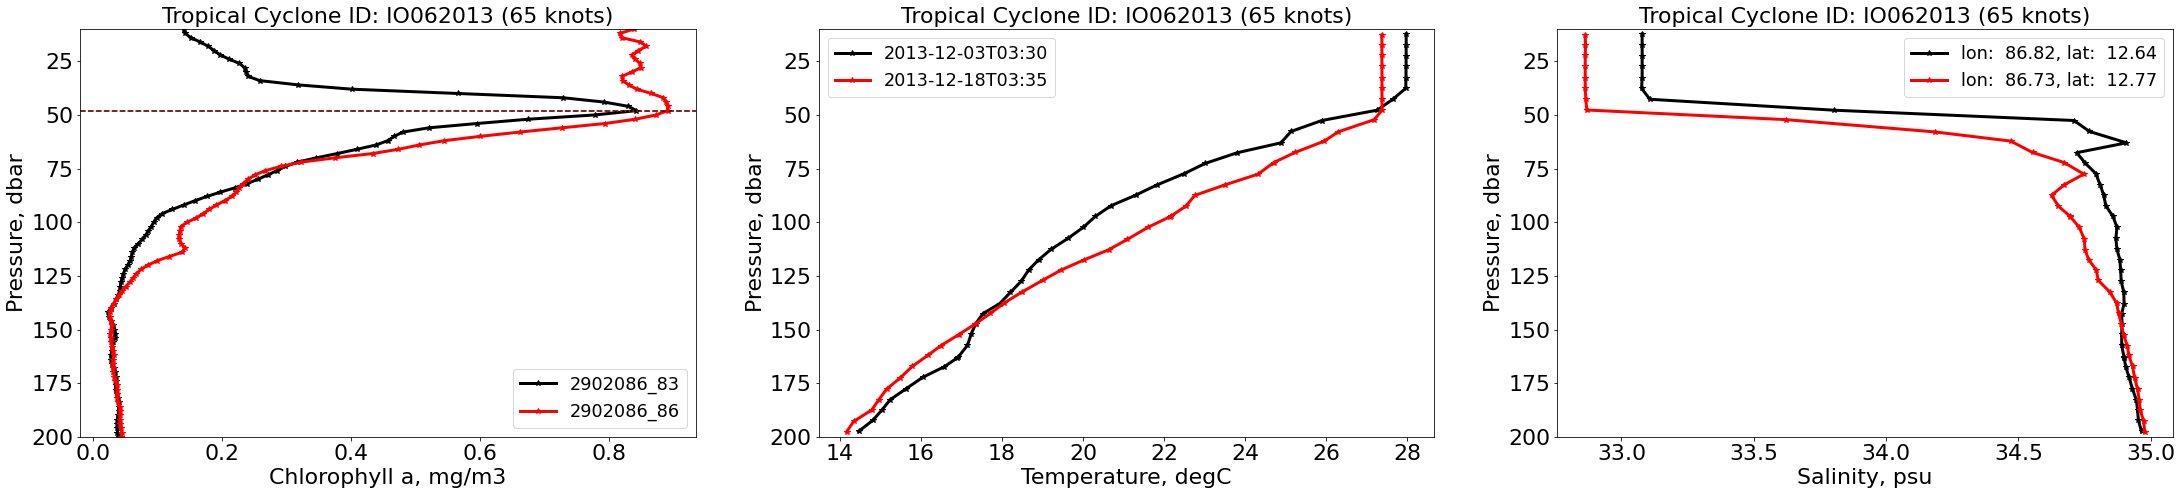

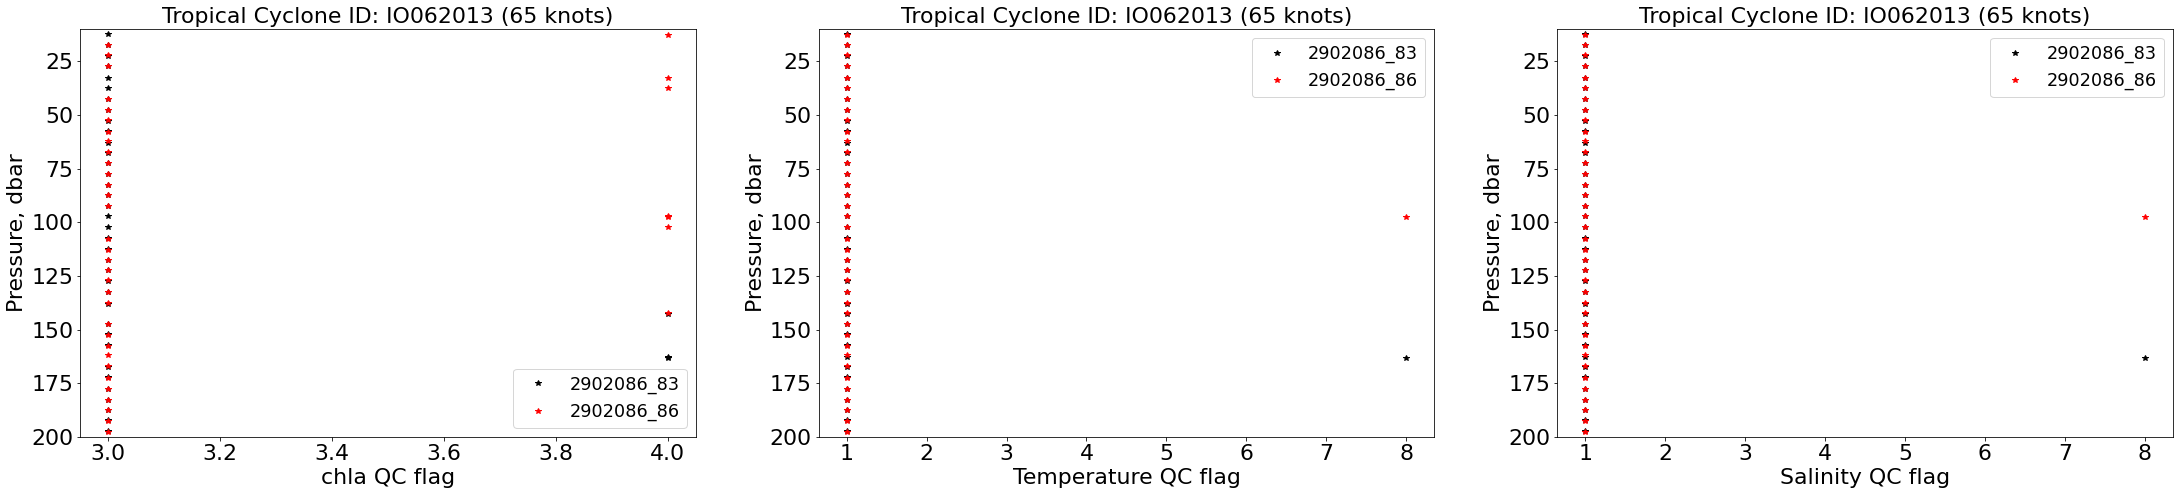

+++++++++++++++ Tropical Cyclone ID: IO032014 +++++++++++++++


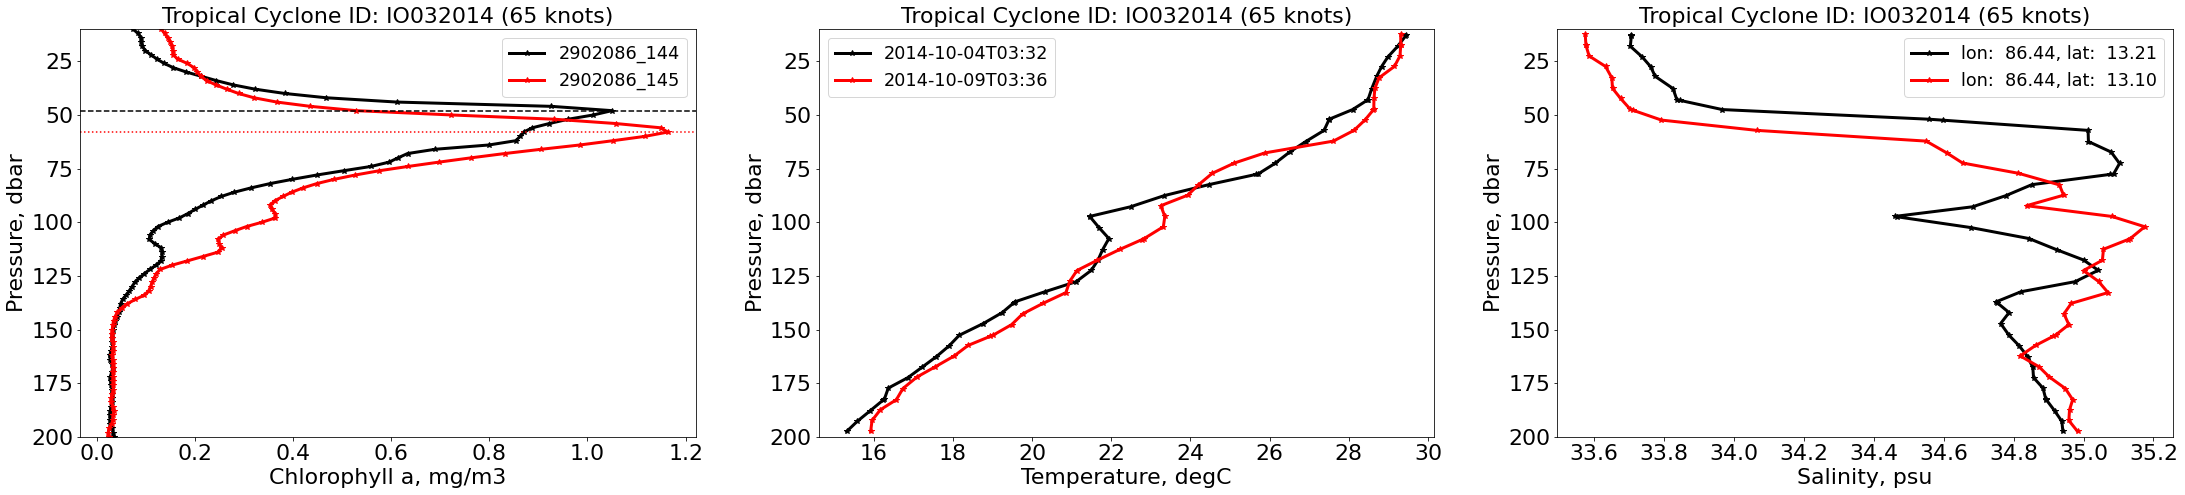

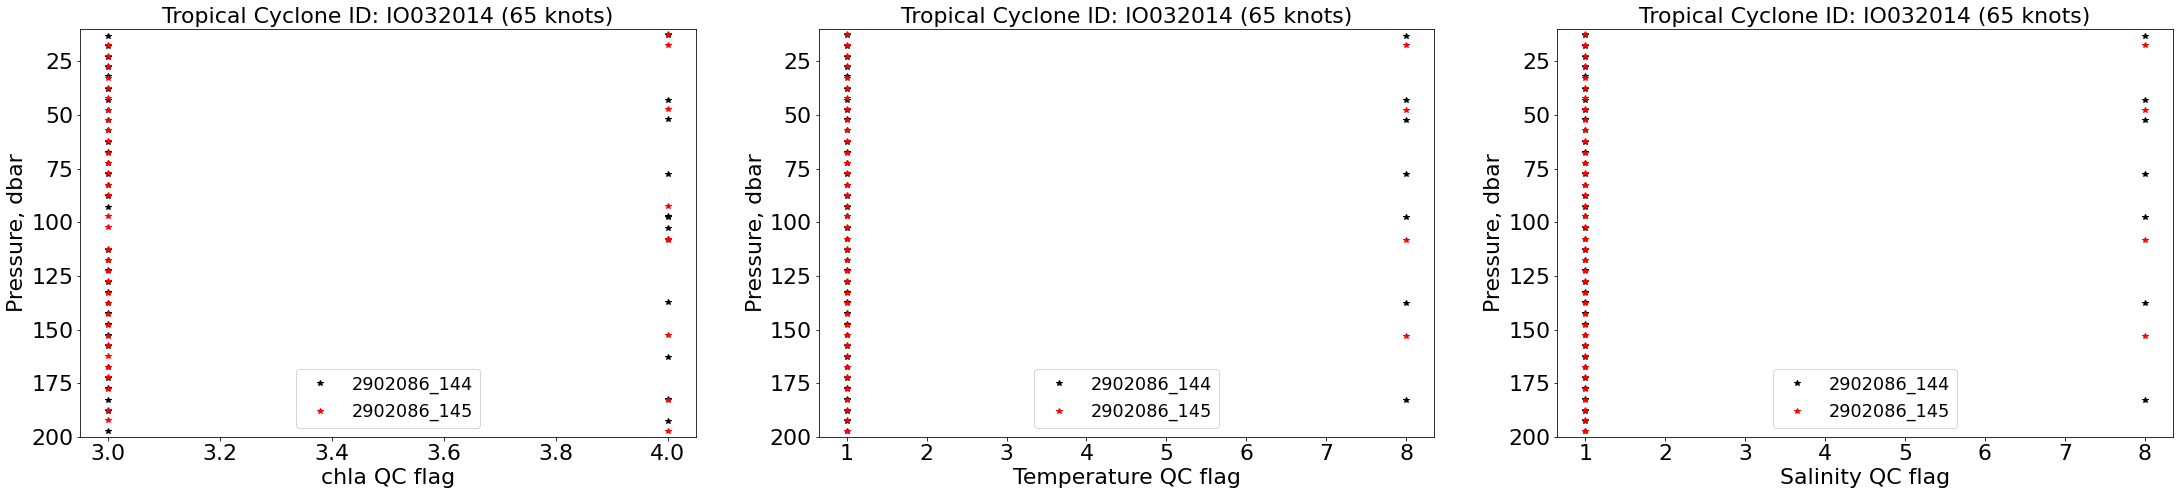

+++++++++++++++ Tropical Cyclone ID: IO052014 +++++++++++++++


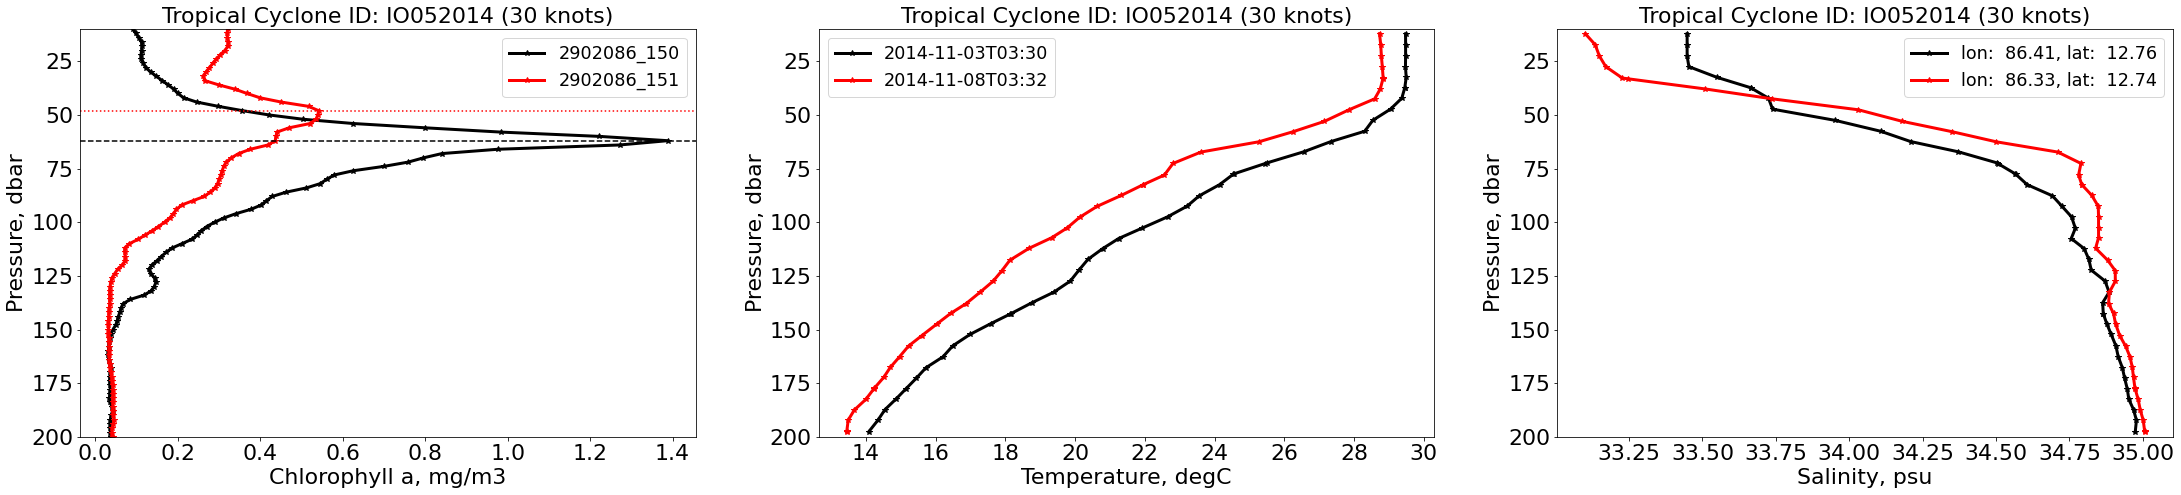

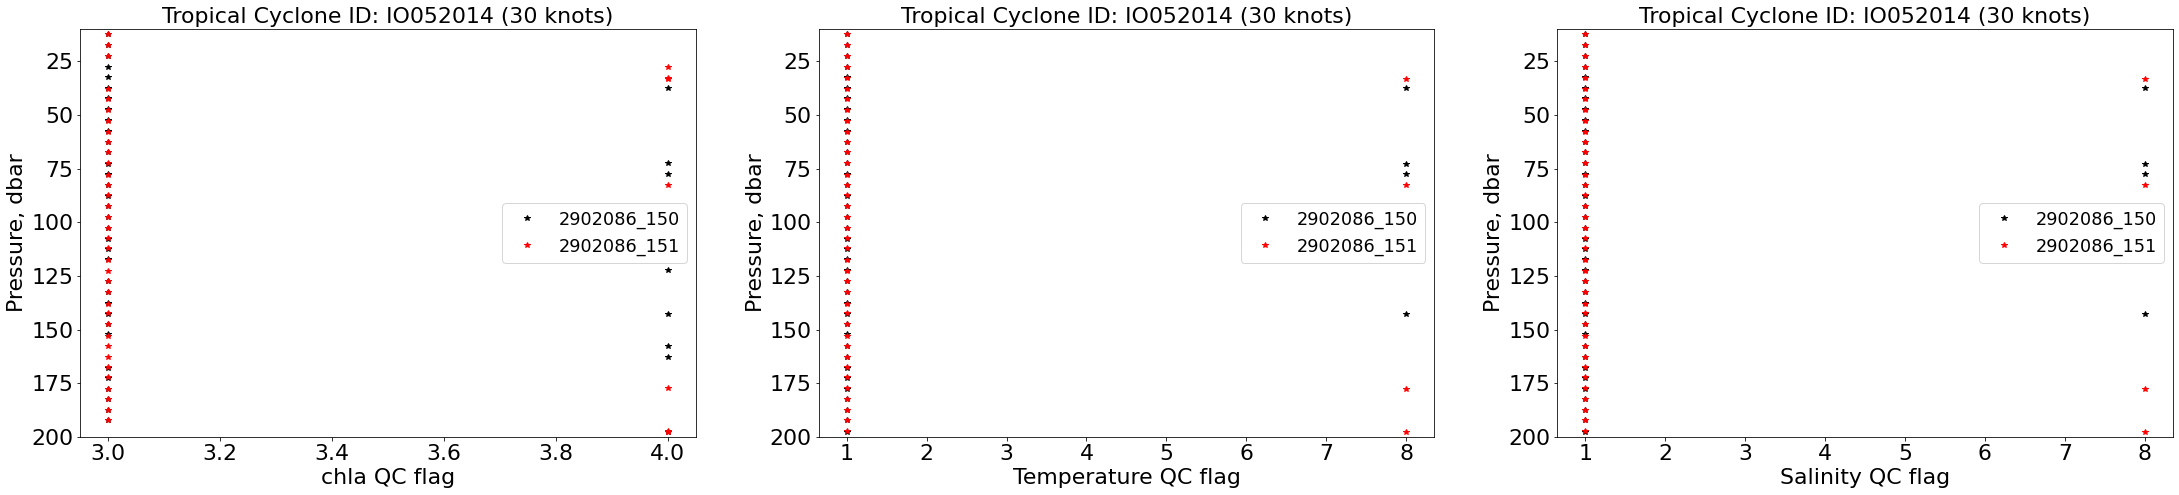

+++++++++++++++ Tropical Cyclone ID: IO052014 +++++++++++++++


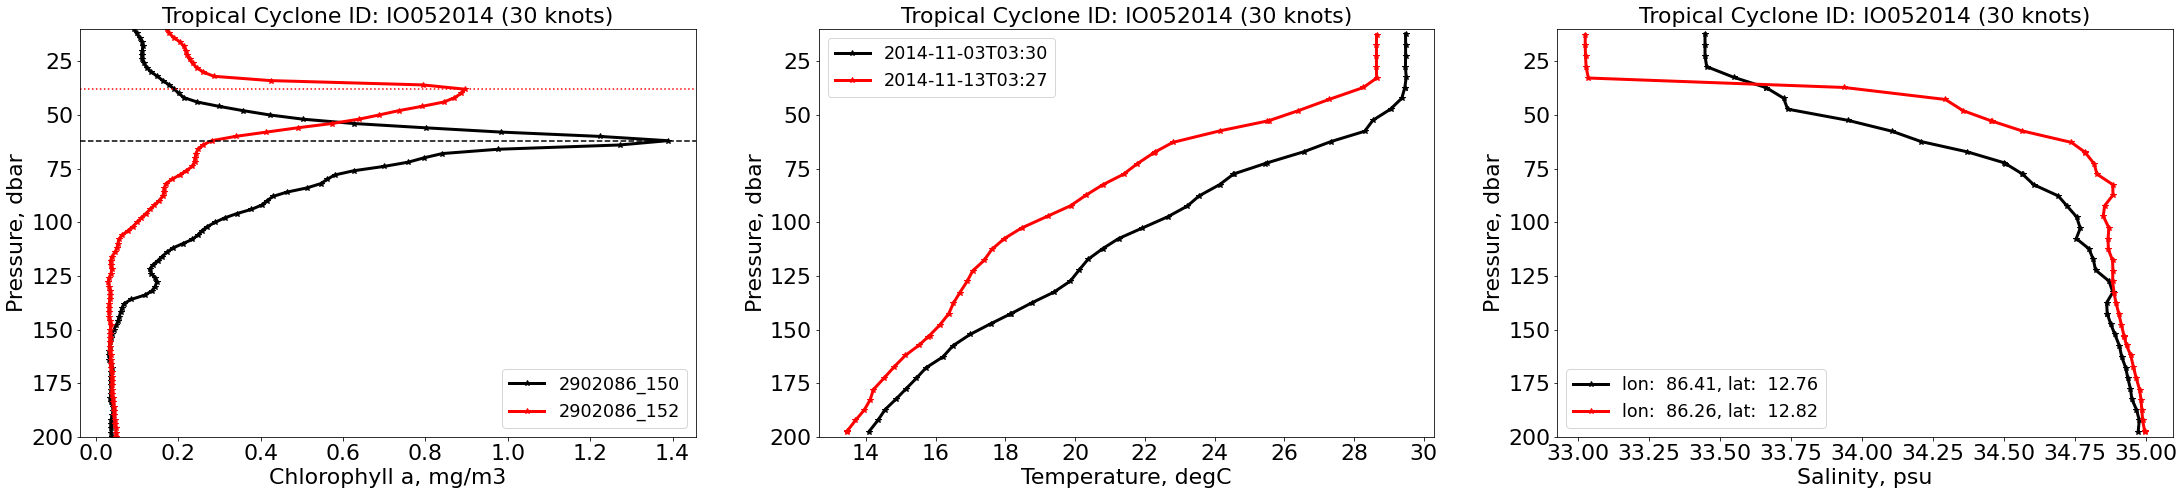

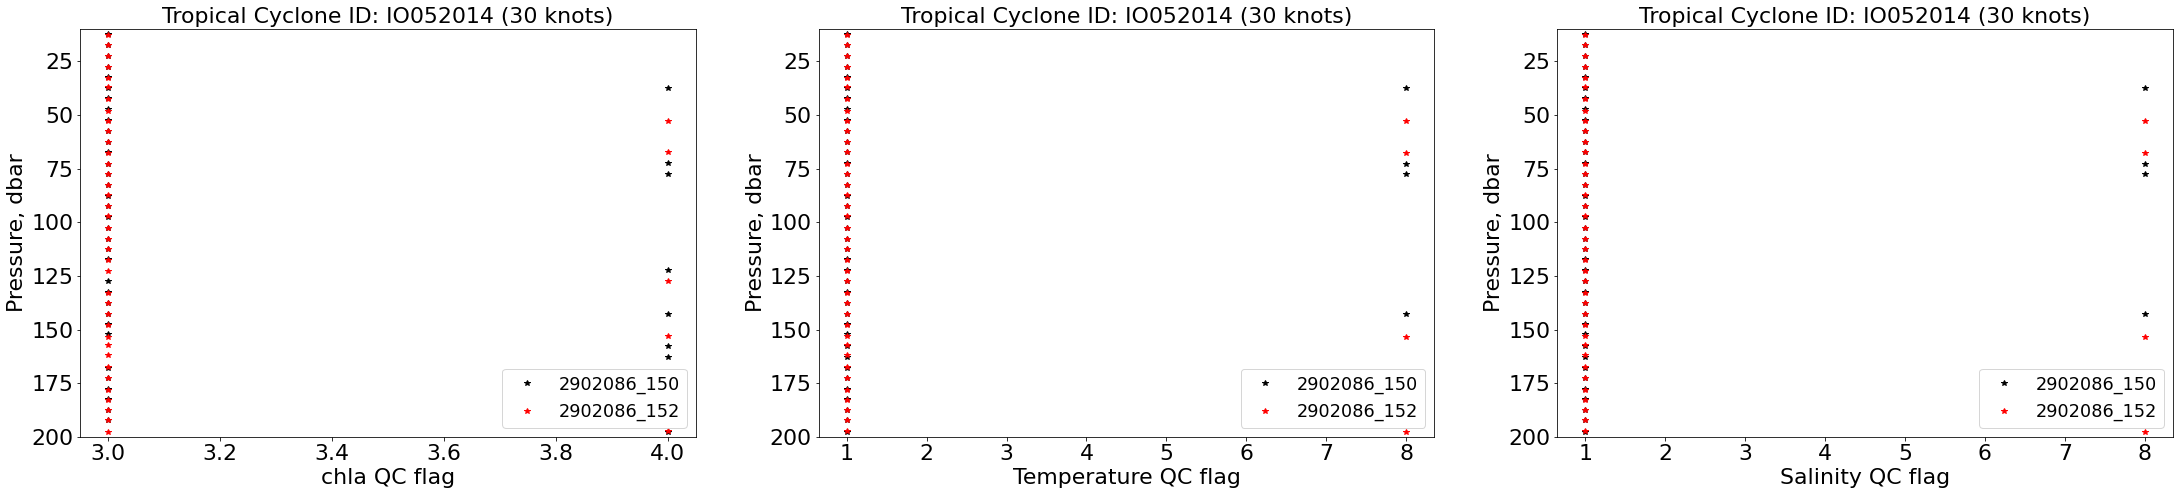

+++++++++++++++ Tropical Cyclone ID: IO052013 +++++++++++++++


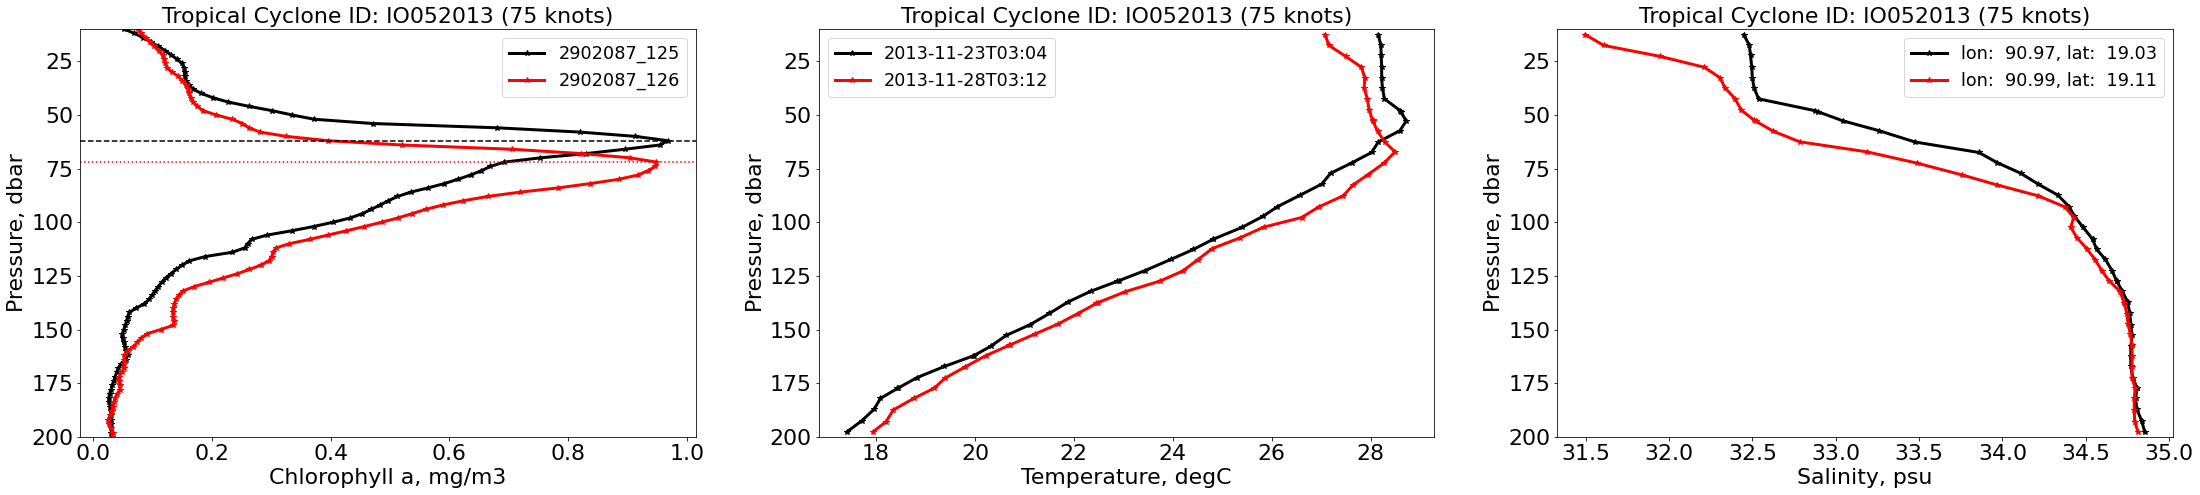

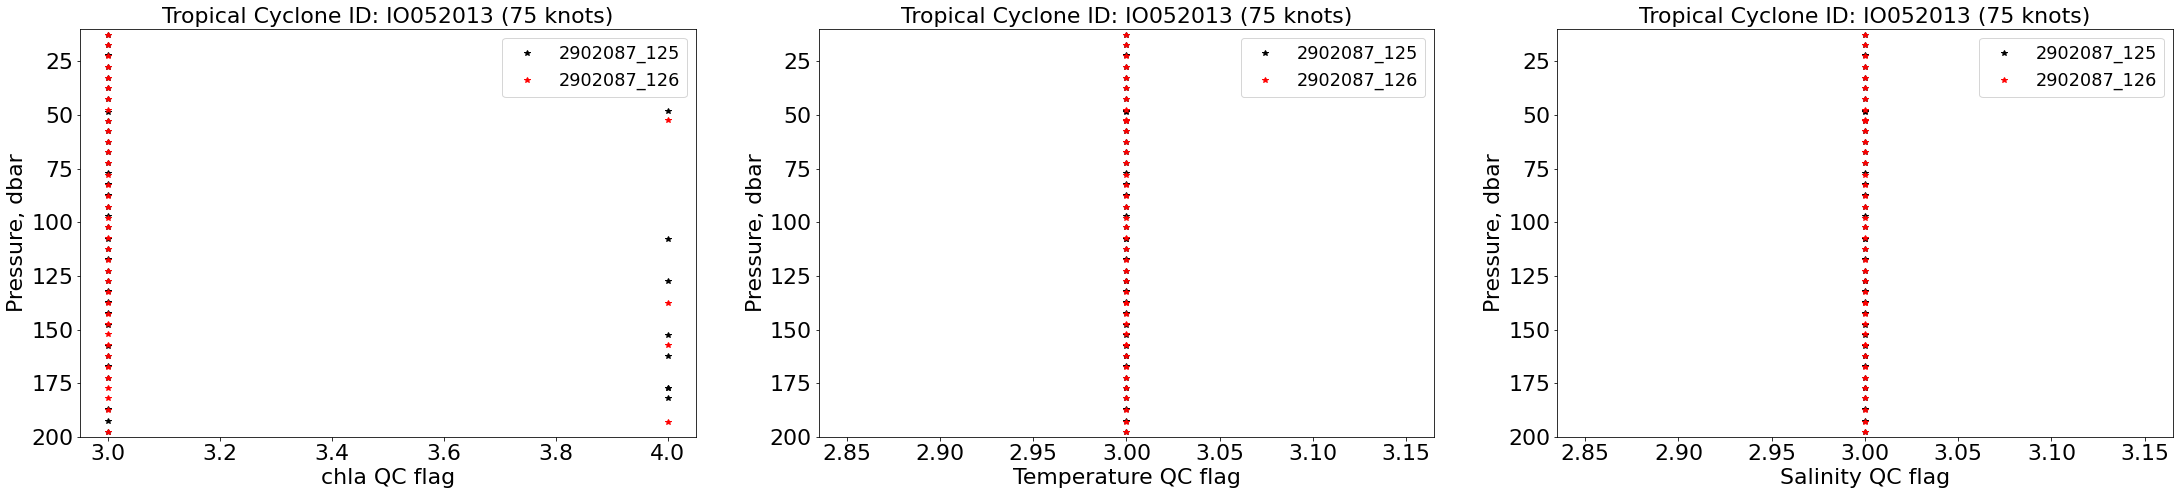

+++++++++++++++ Tropical Cyclone ID: IO052013 +++++++++++++++


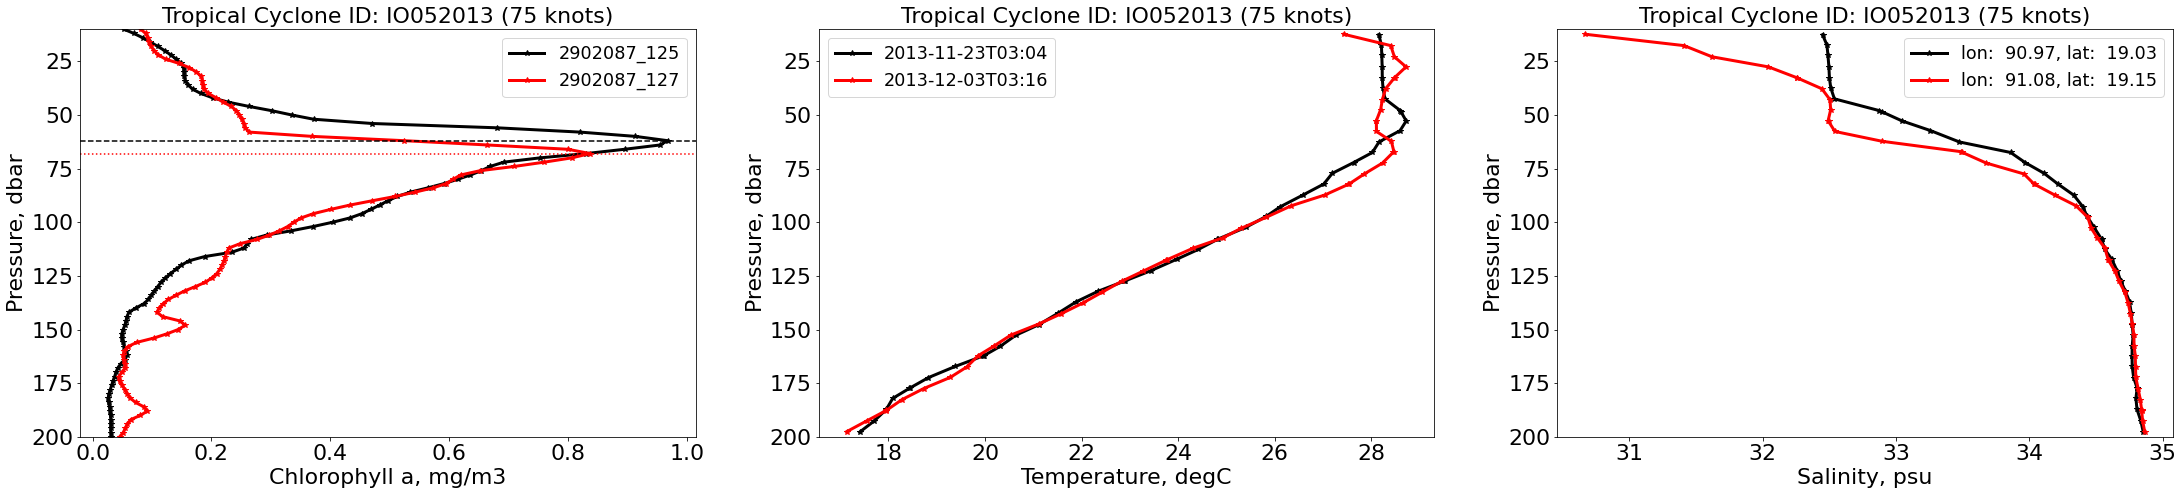

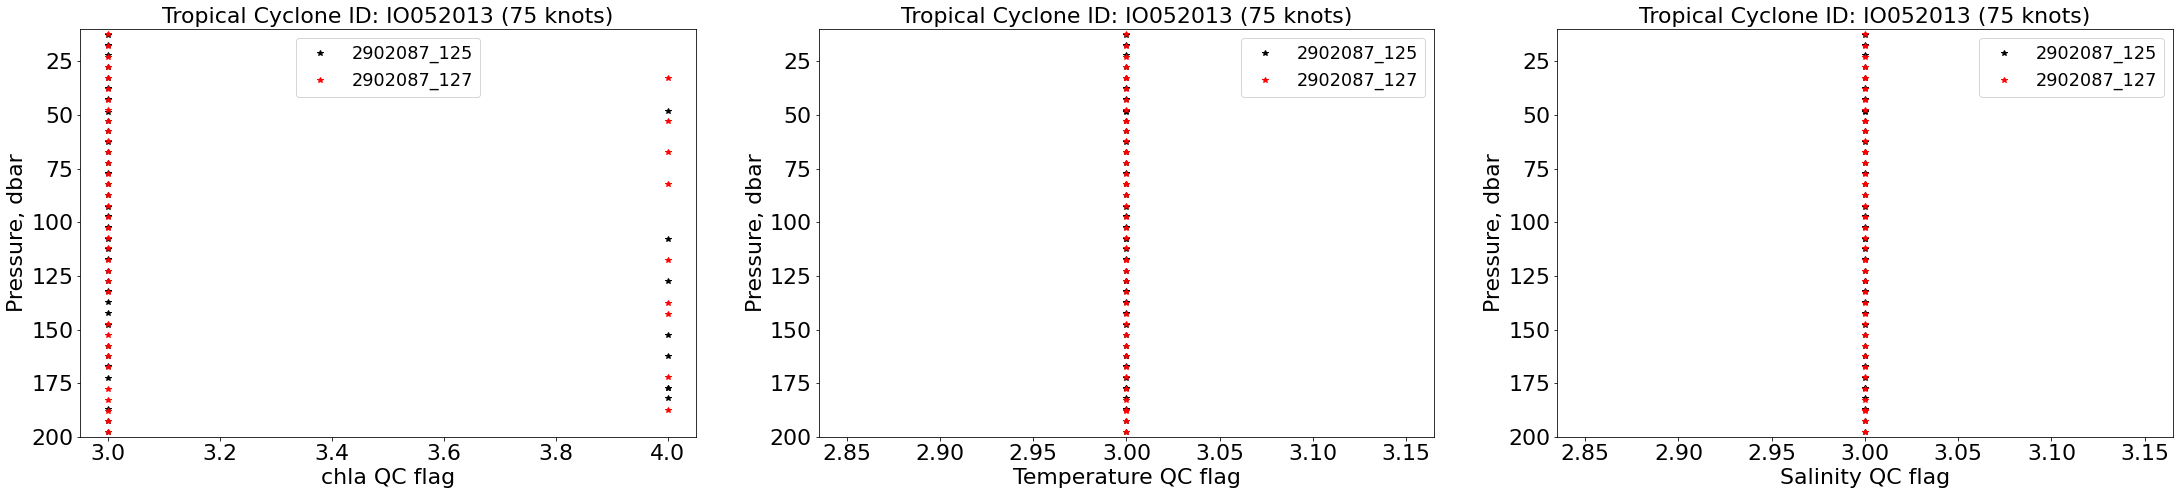

+++++++++++++++ Tropical Cyclone ID: IO052013 +++++++++++++++


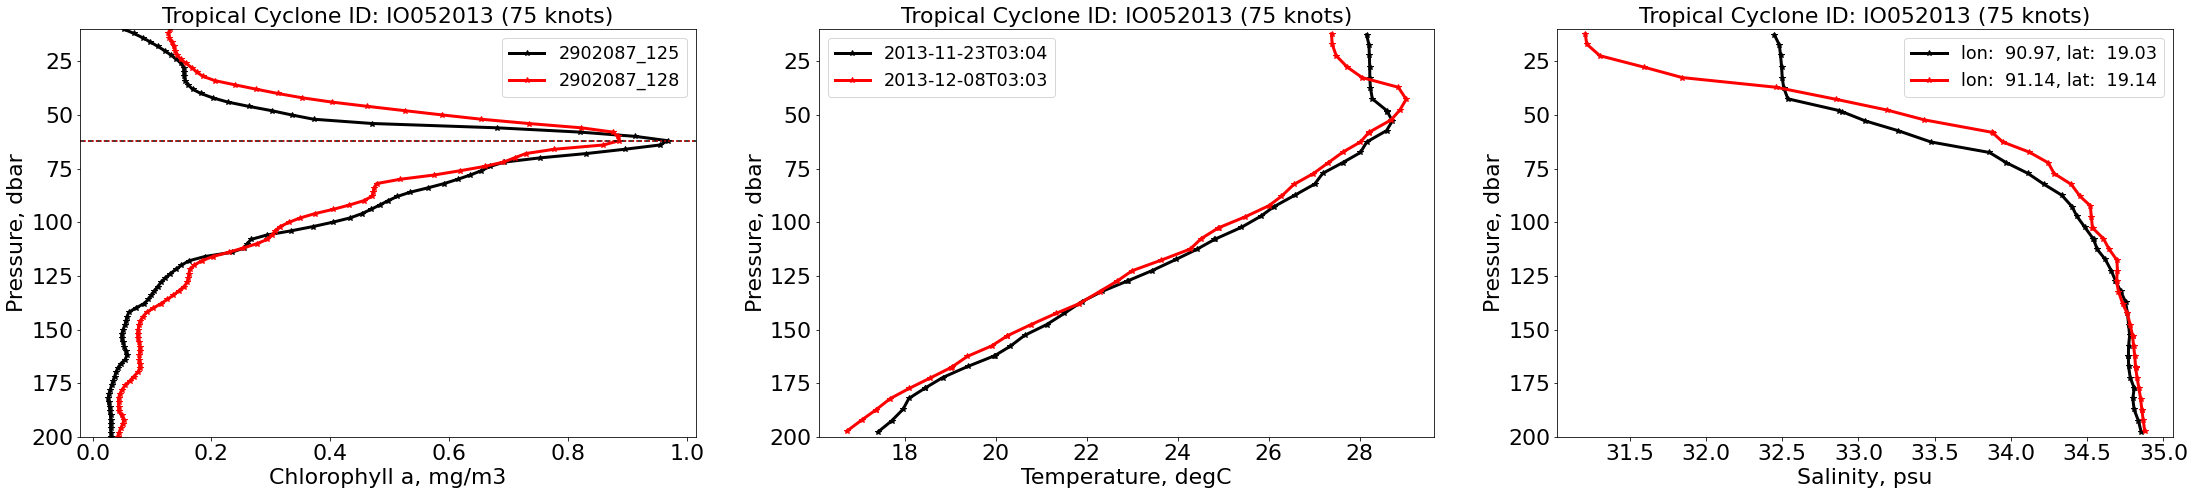

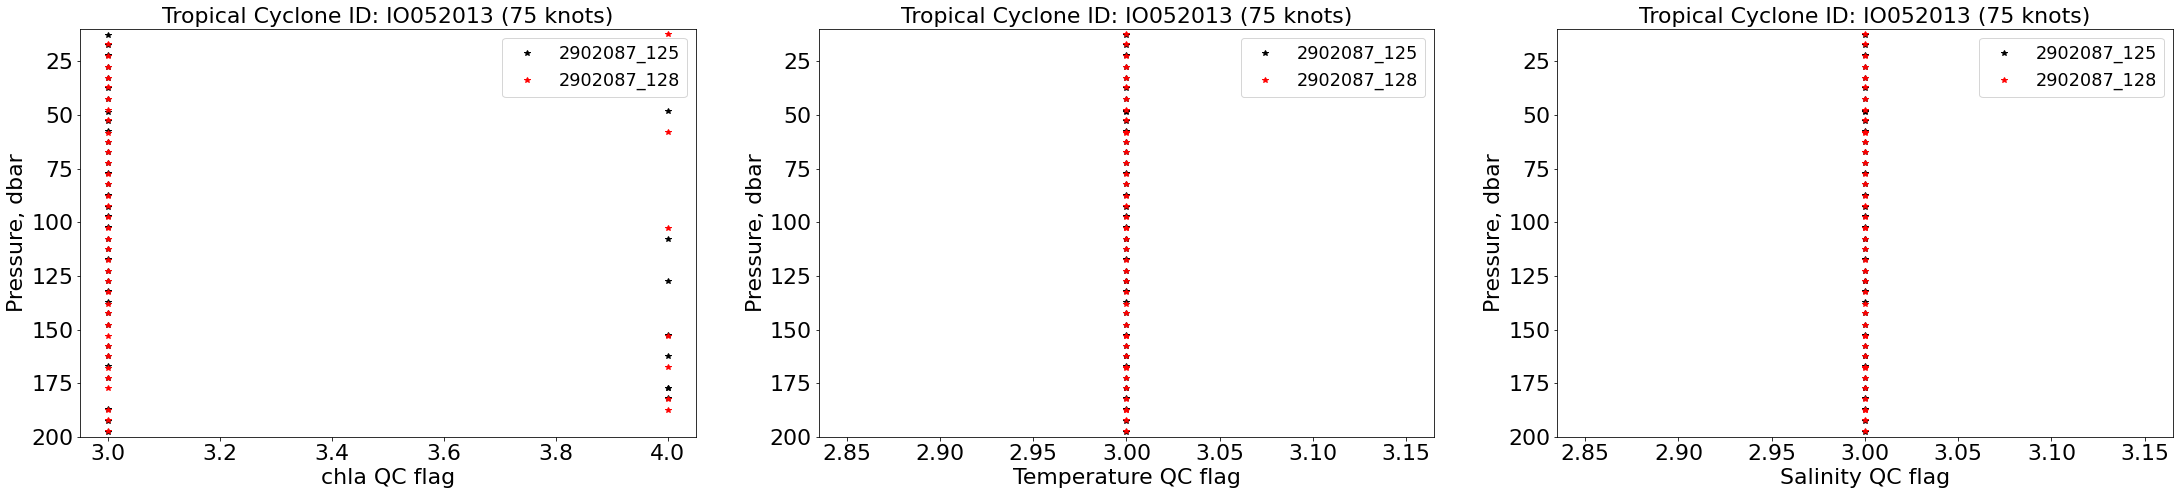

+++++++++++++++ Tropical Cyclone ID: IO062013 +++++++++++++++


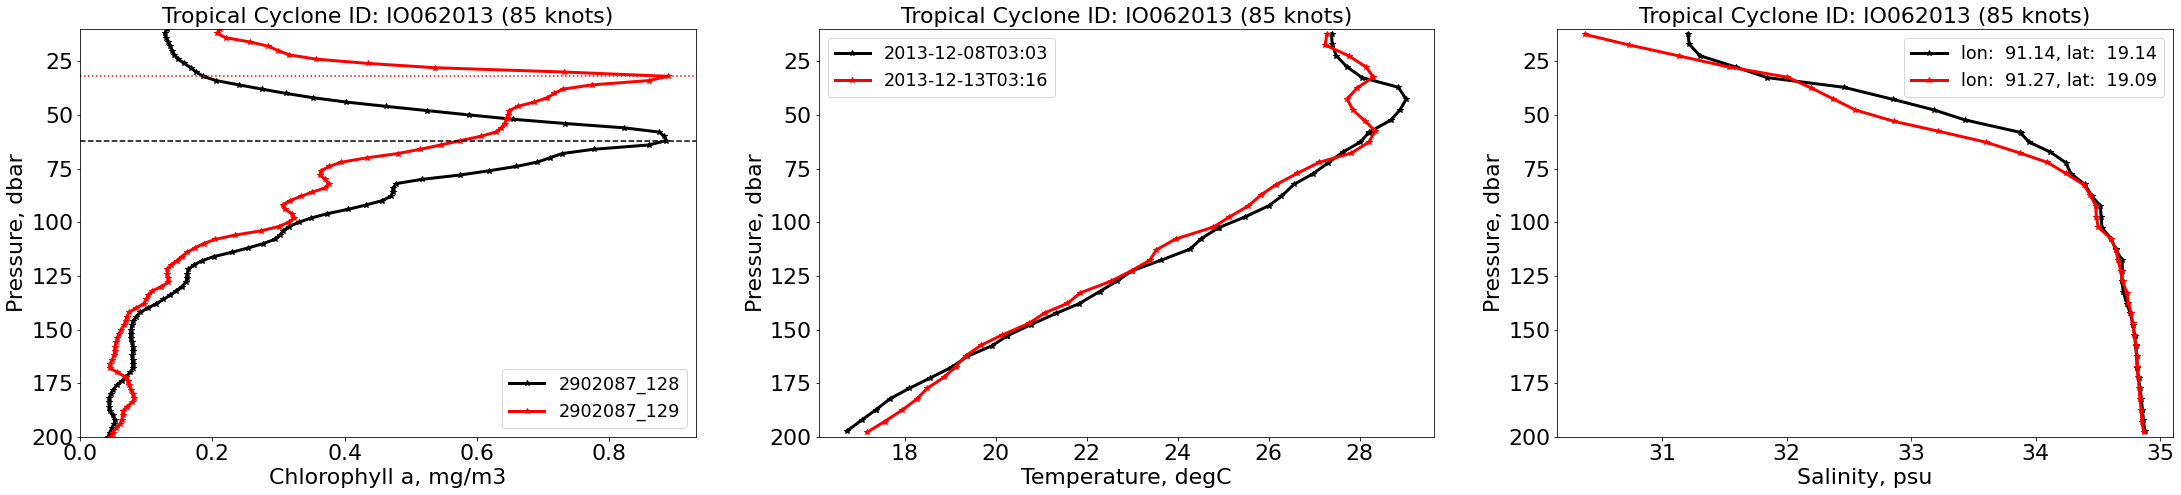

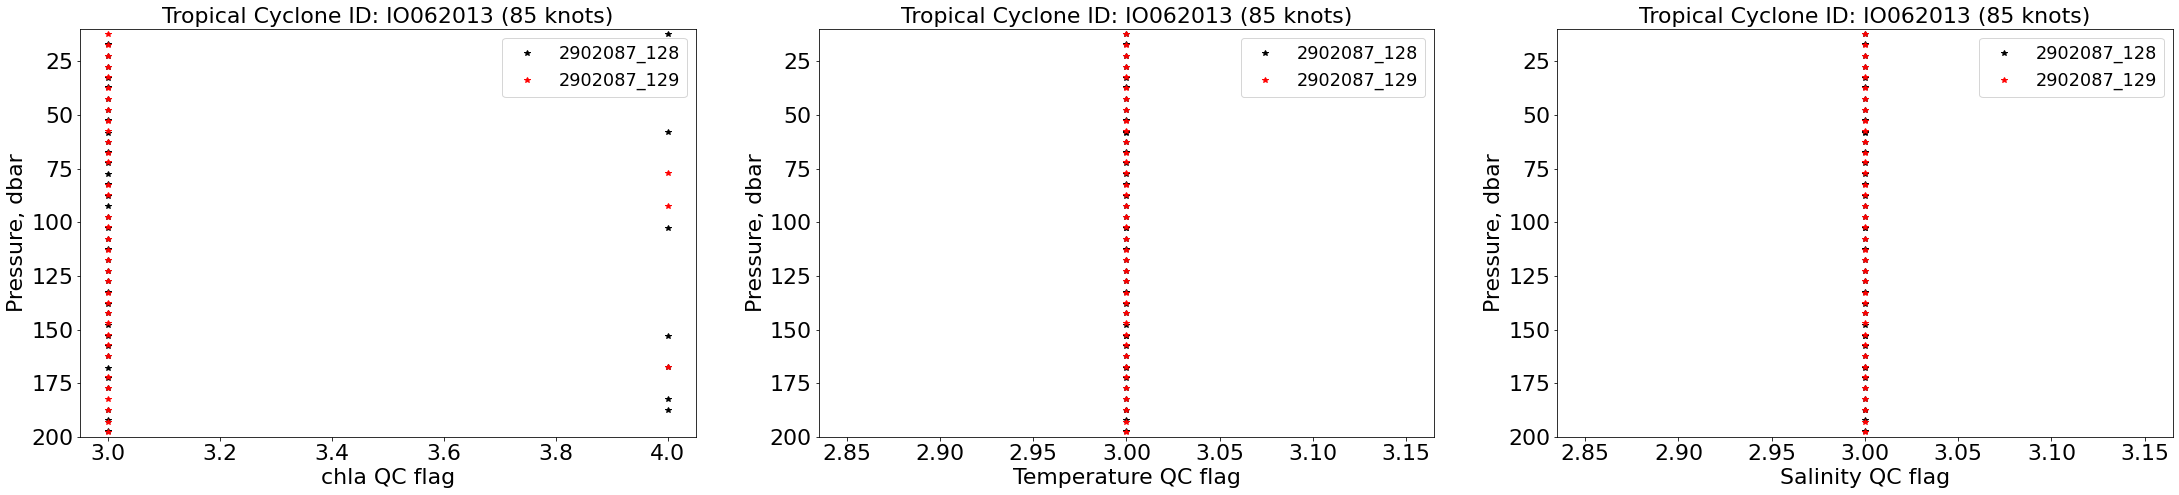

+++++++++++++++ Tropical Cyclone ID: IO062013 +++++++++++++++


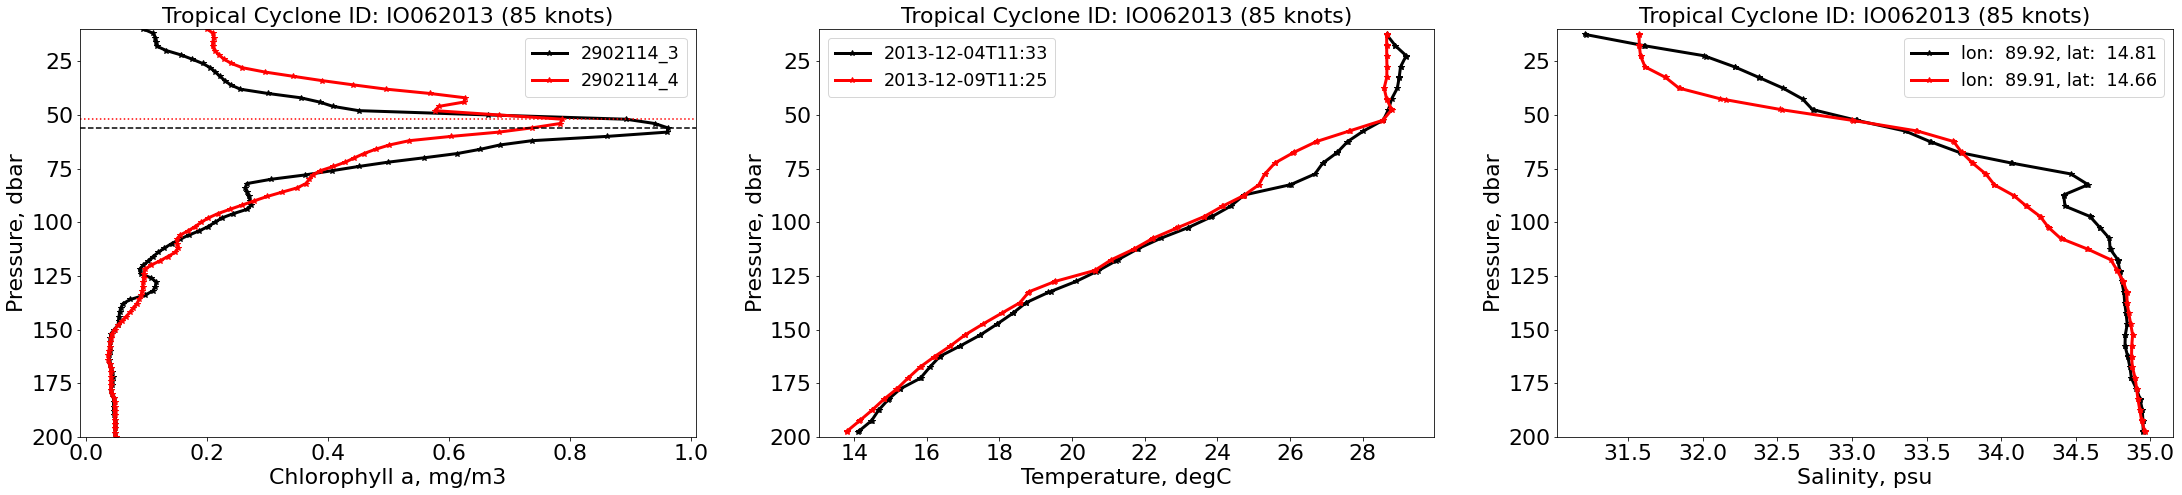

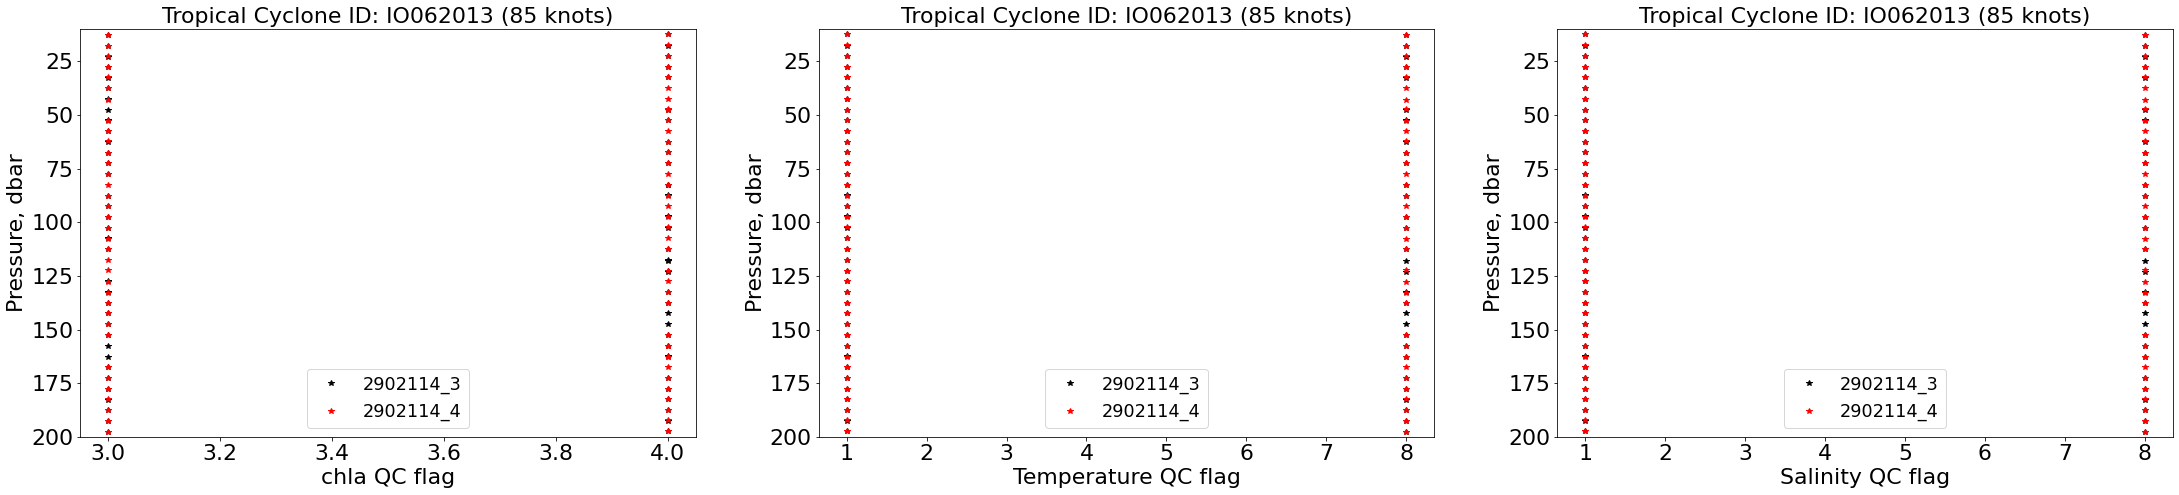

+++++++++++++++ Tropical Cyclone ID: IO012014 +++++++++++++++


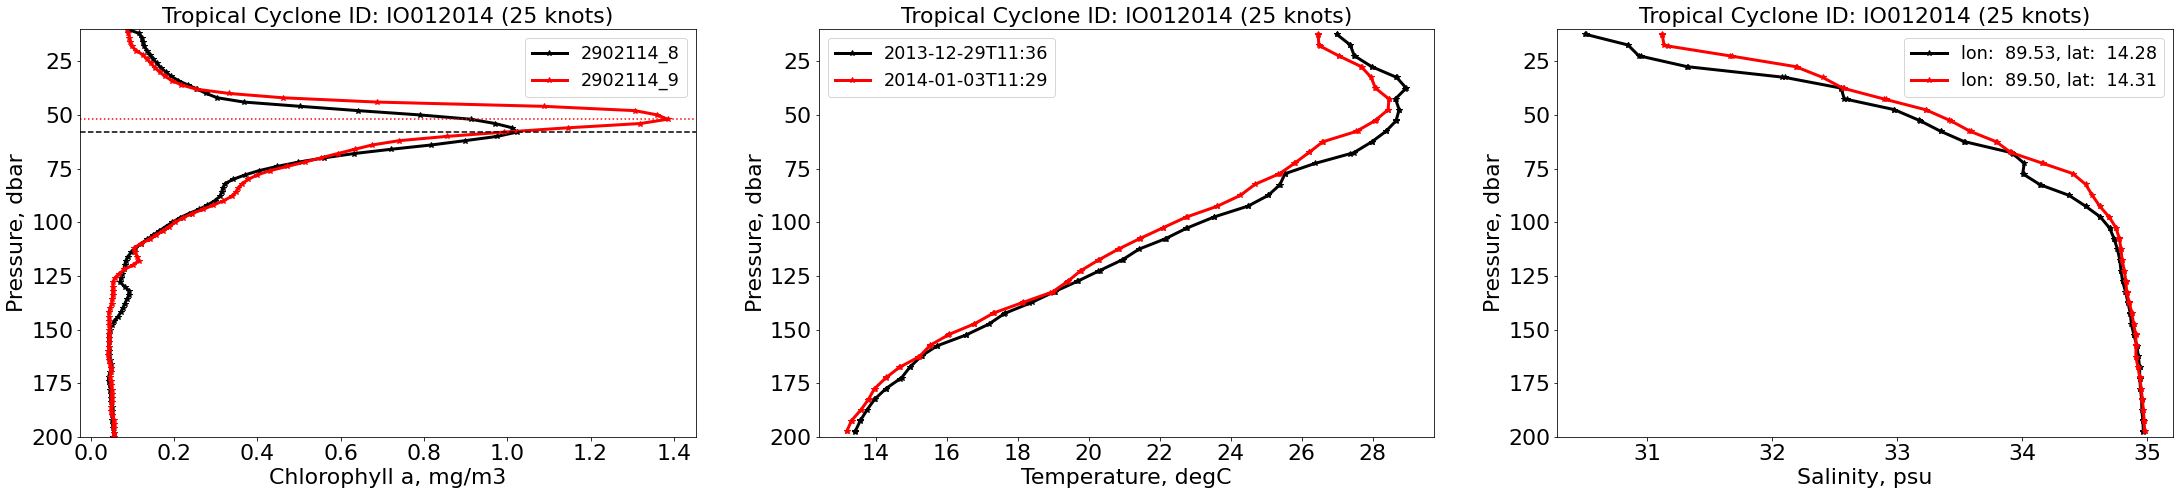

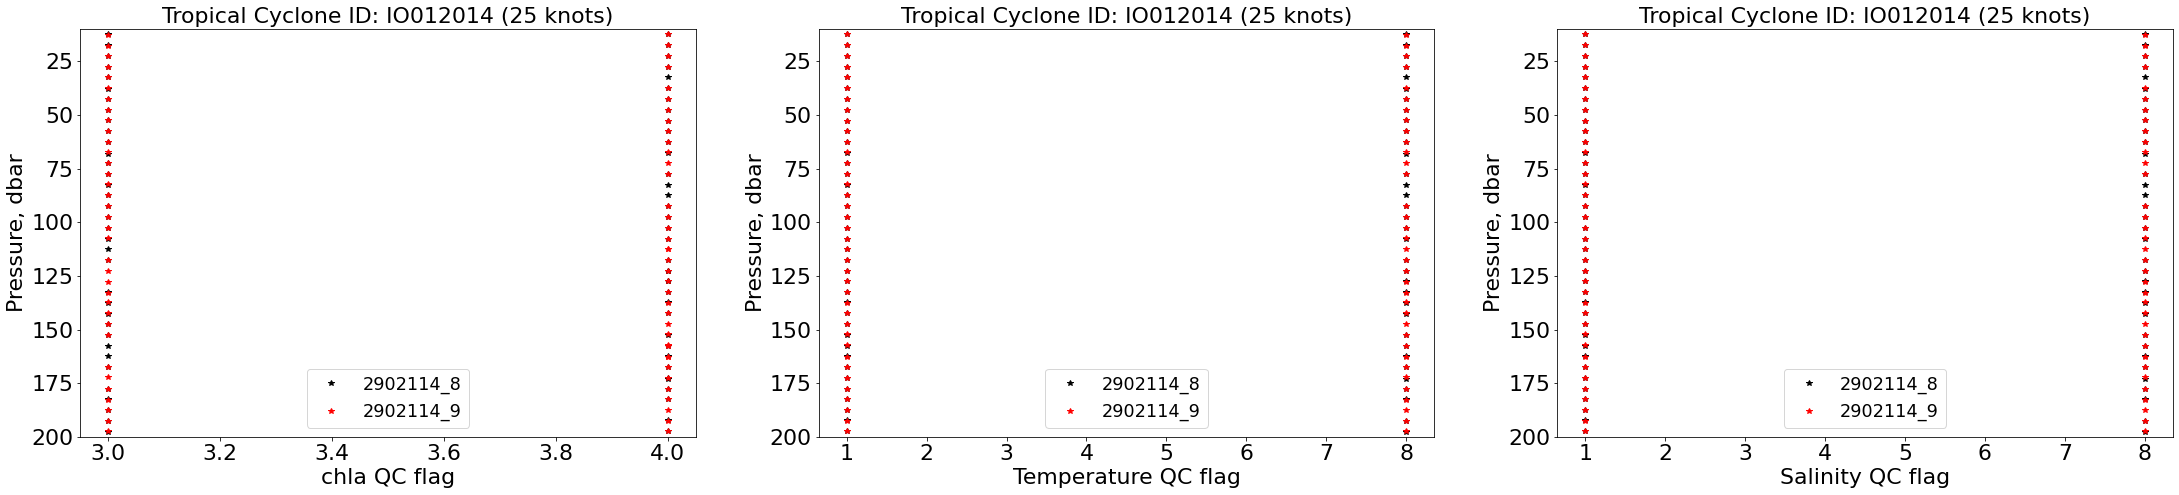

+++++++++++++++ Tropical Cyclone ID: IO012014 +++++++++++++++


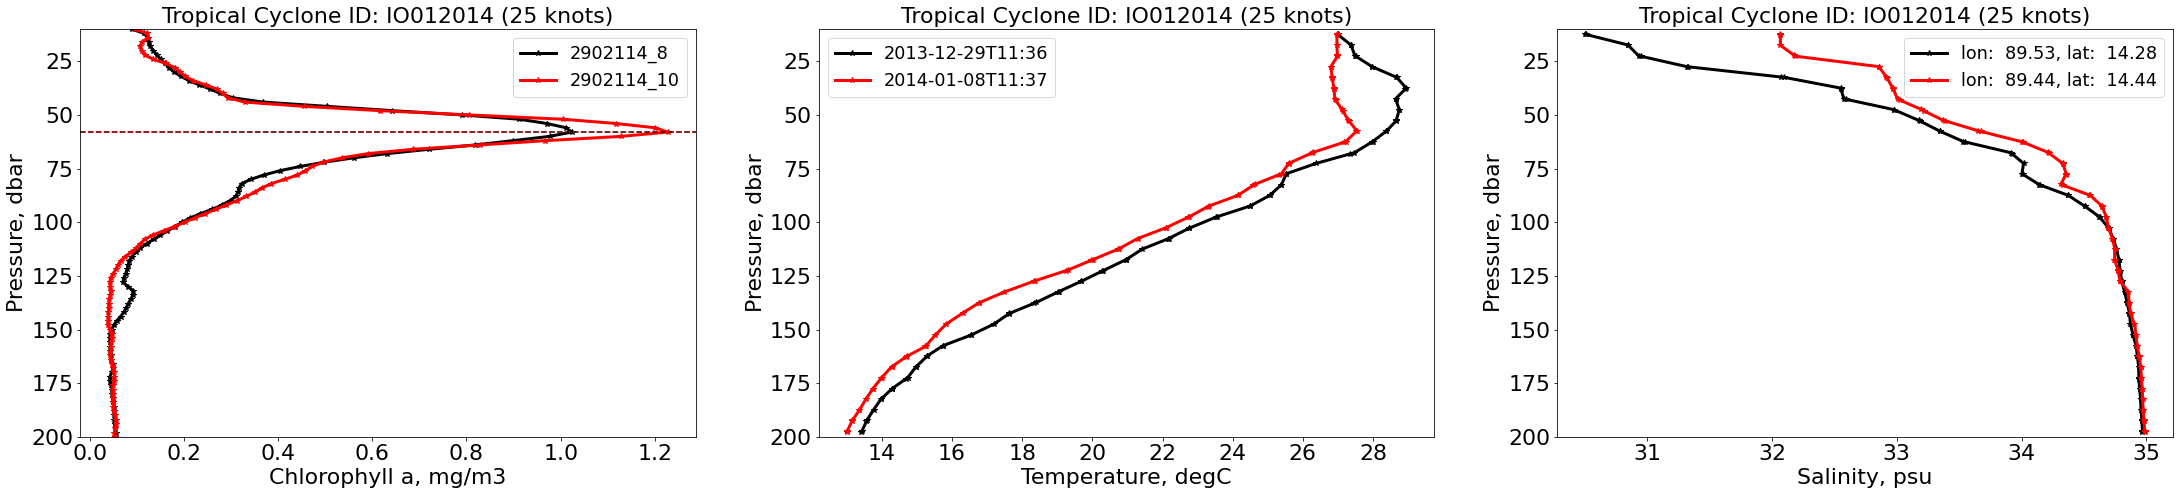

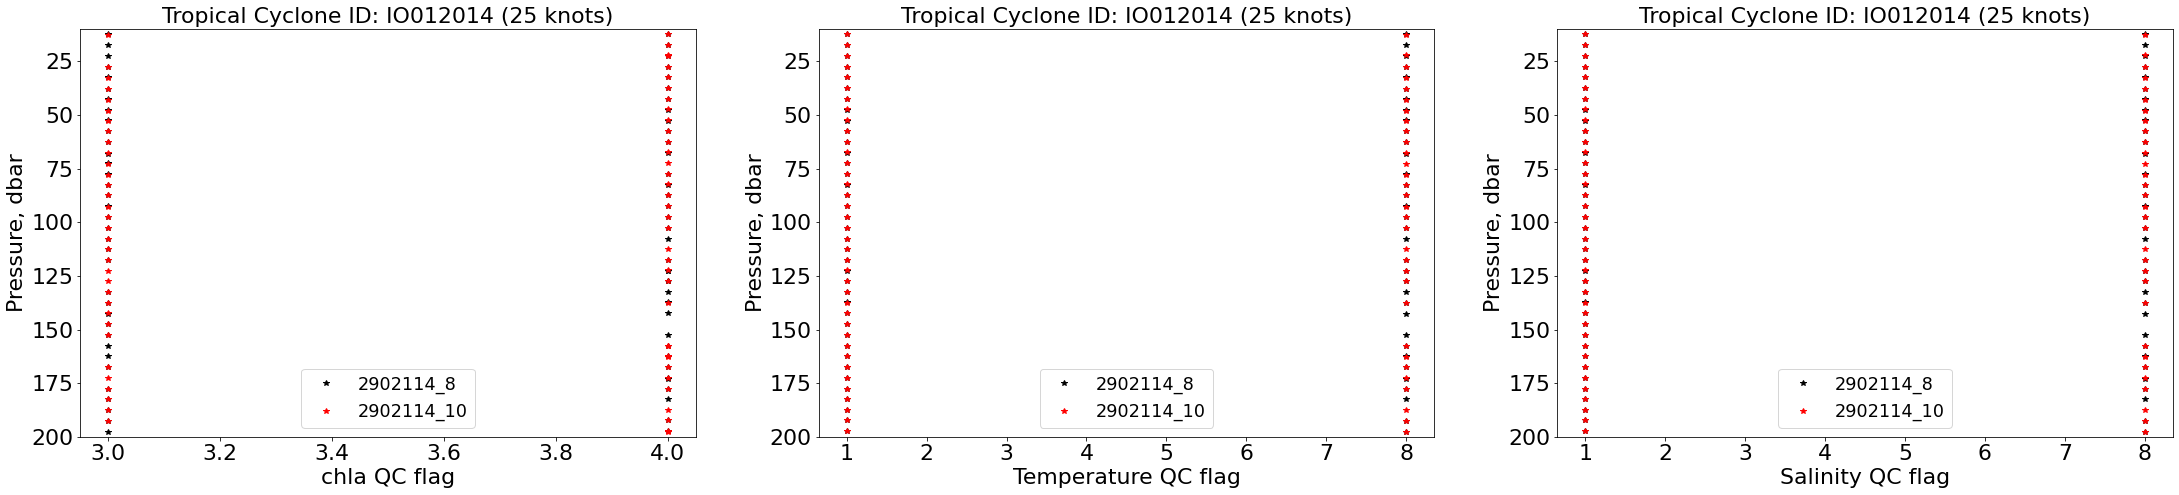

+++++++++++++++ Tropical Cyclone ID: IO032014 +++++++++++++++


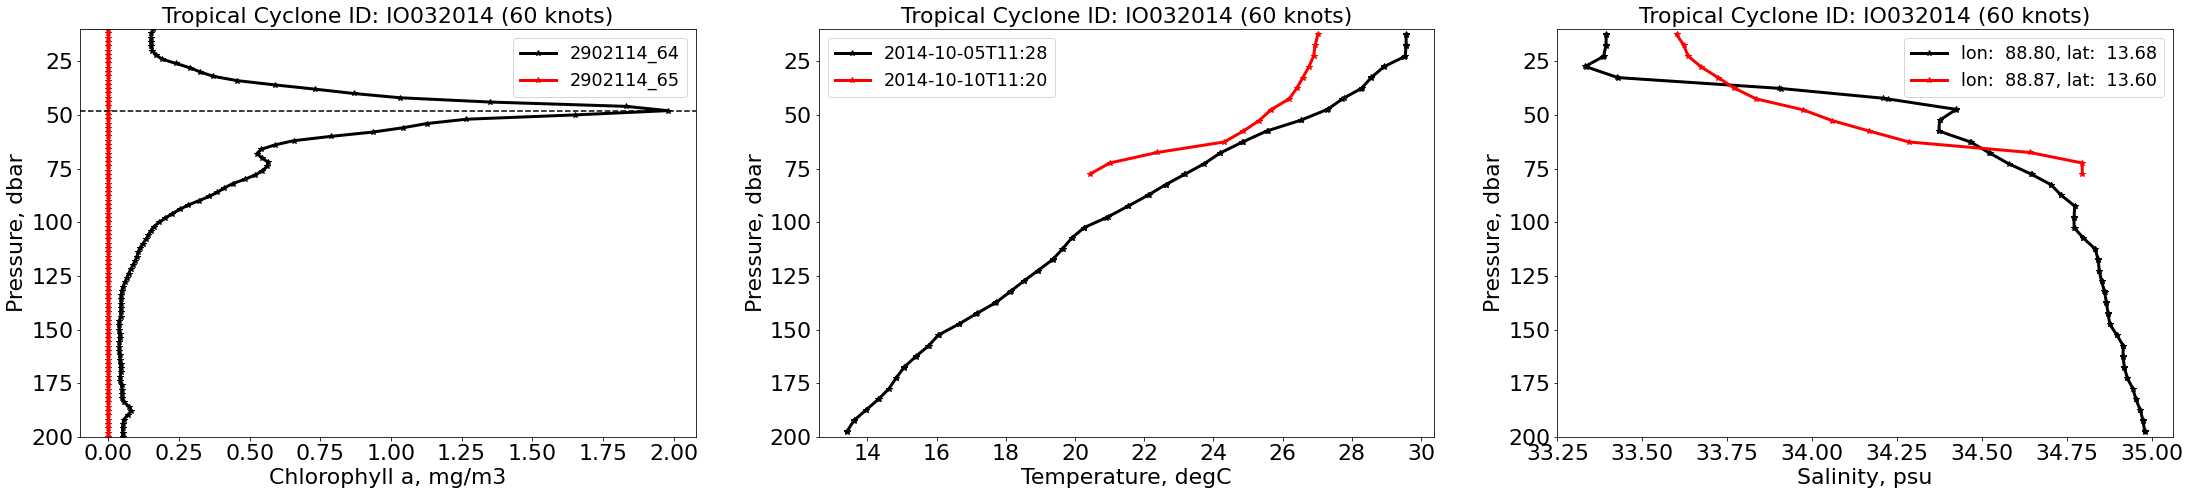

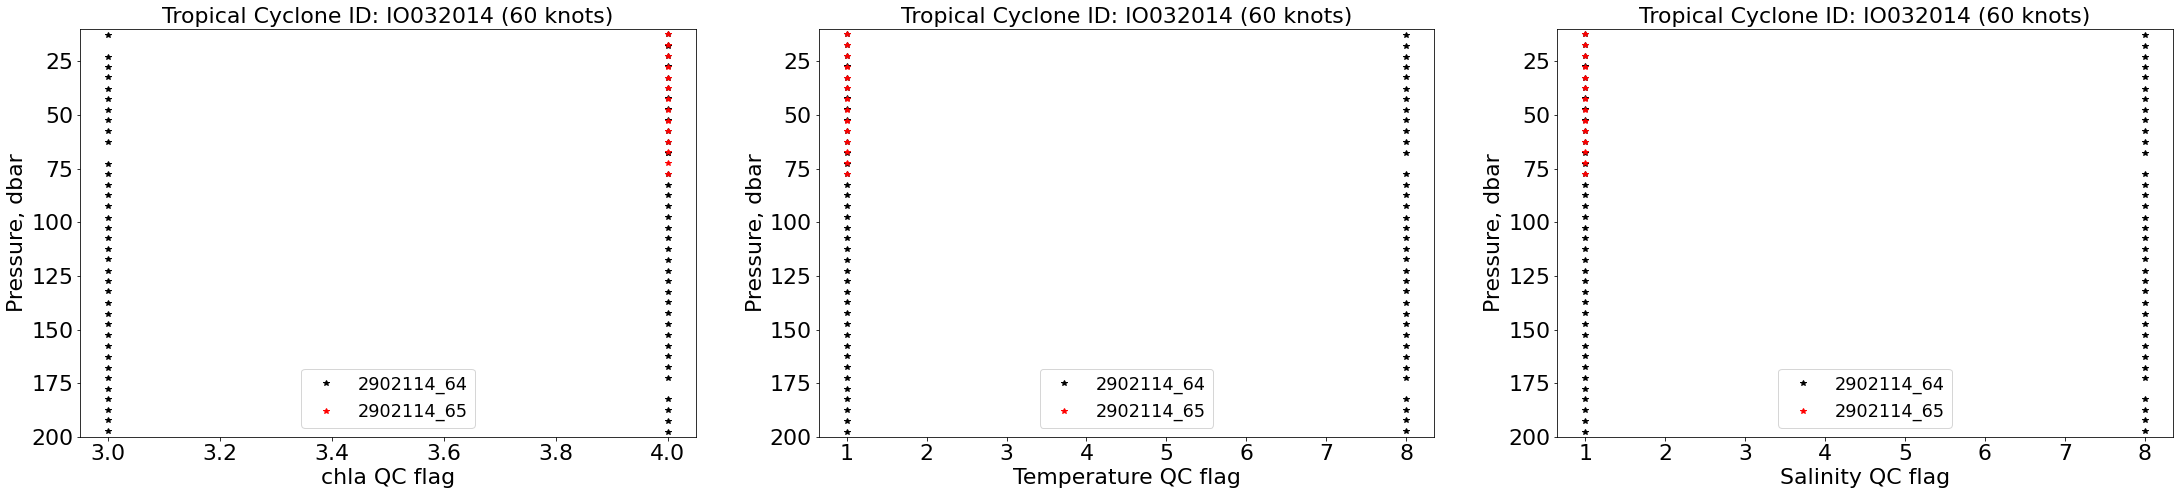

+++++++++++++++ Tropical Cyclone ID: IO032014 +++++++++++++++


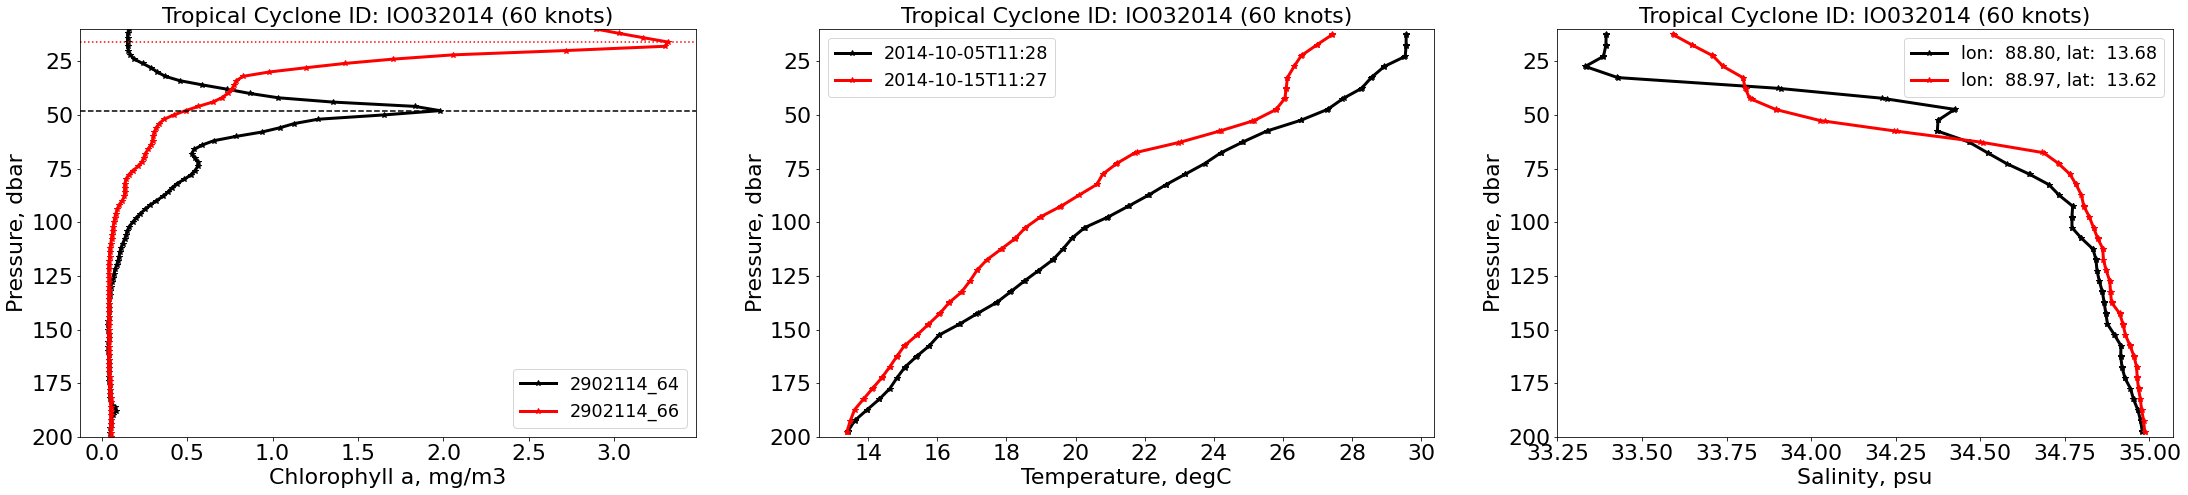

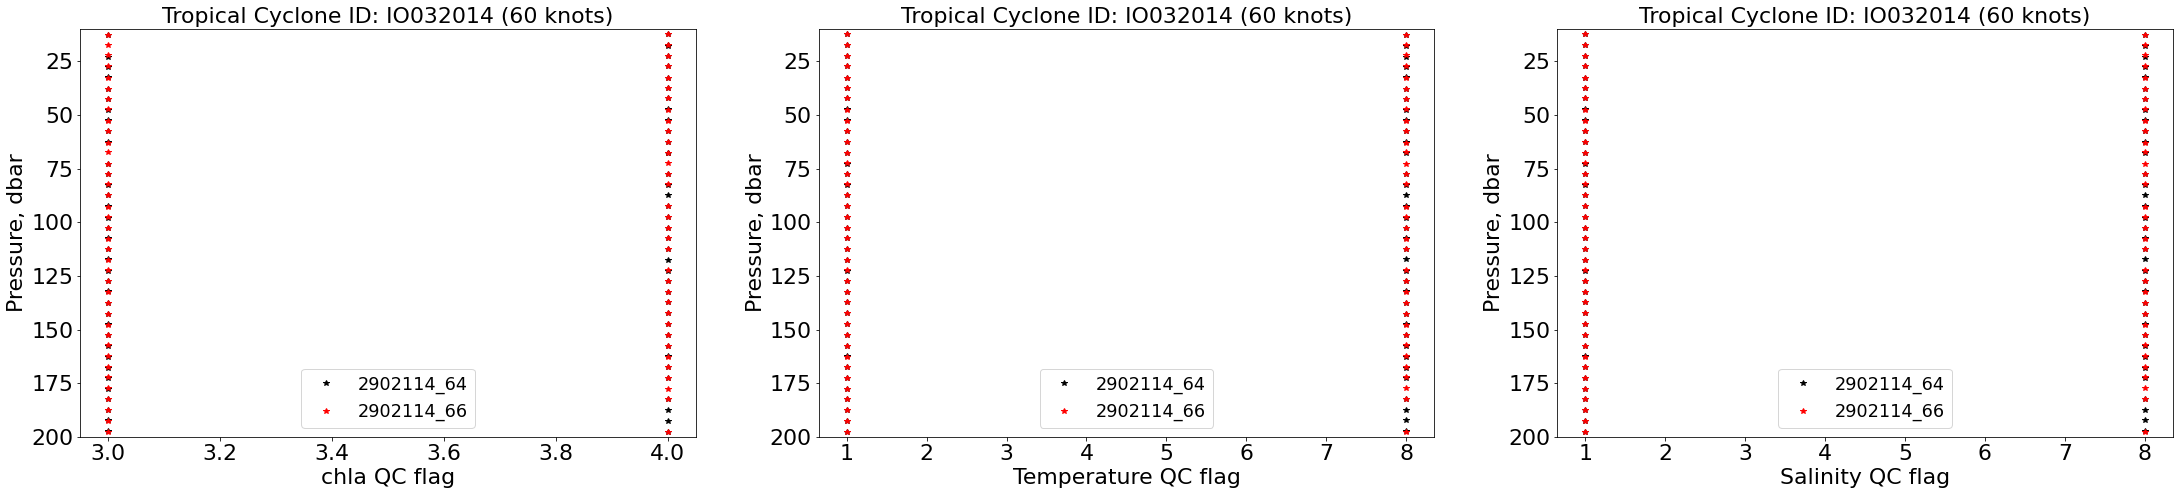

+++++++++++++++ Tropical Cyclone ID: IO052014 +++++++++++++++


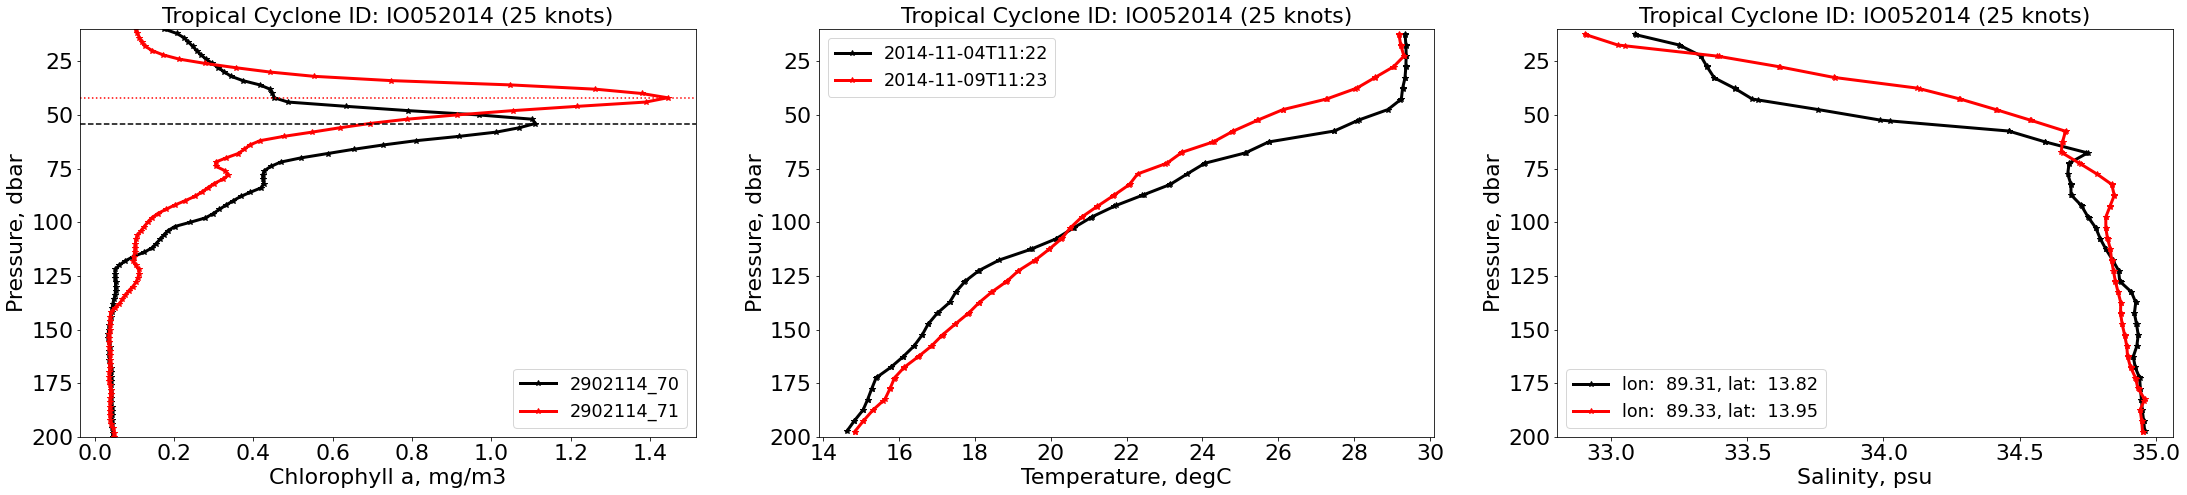

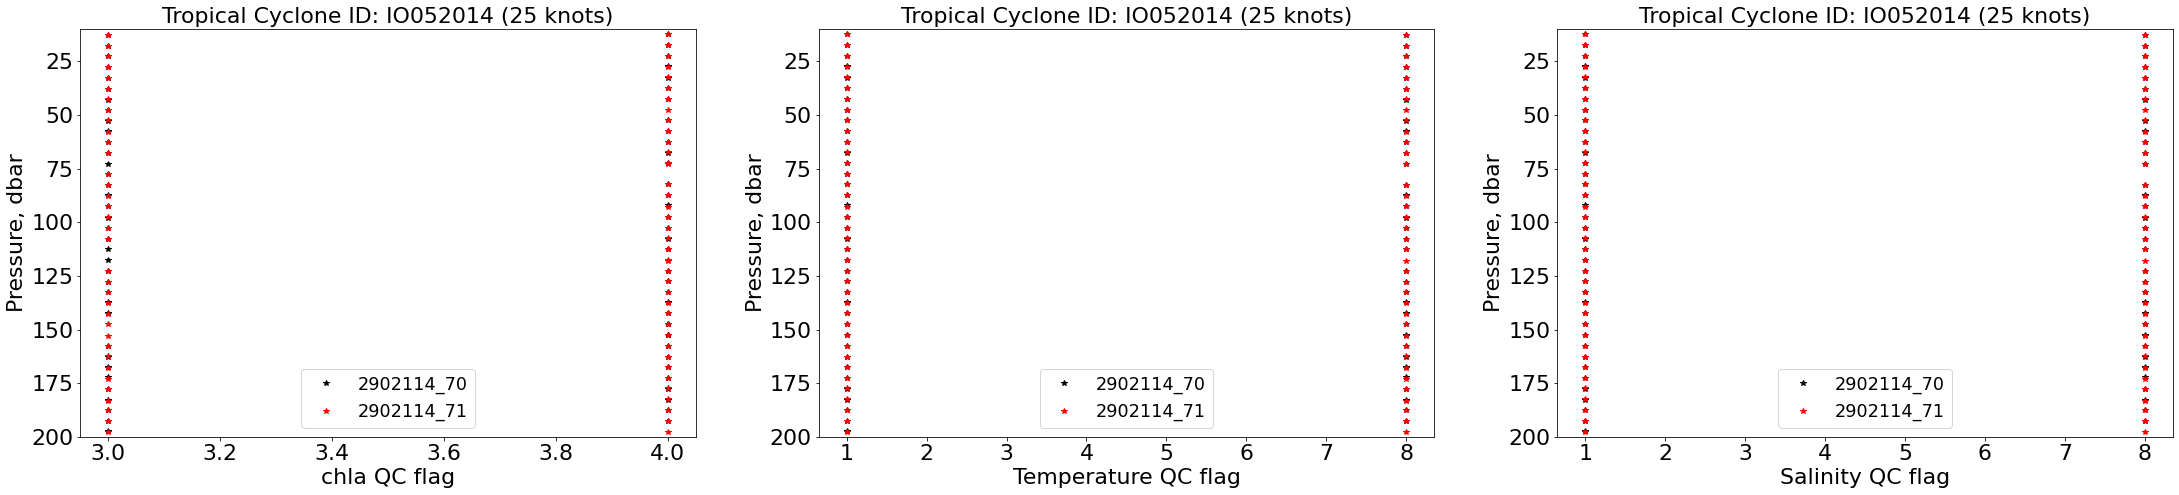

+++++++++++++++ Tropical Cyclone ID: IO052014 +++++++++++++++


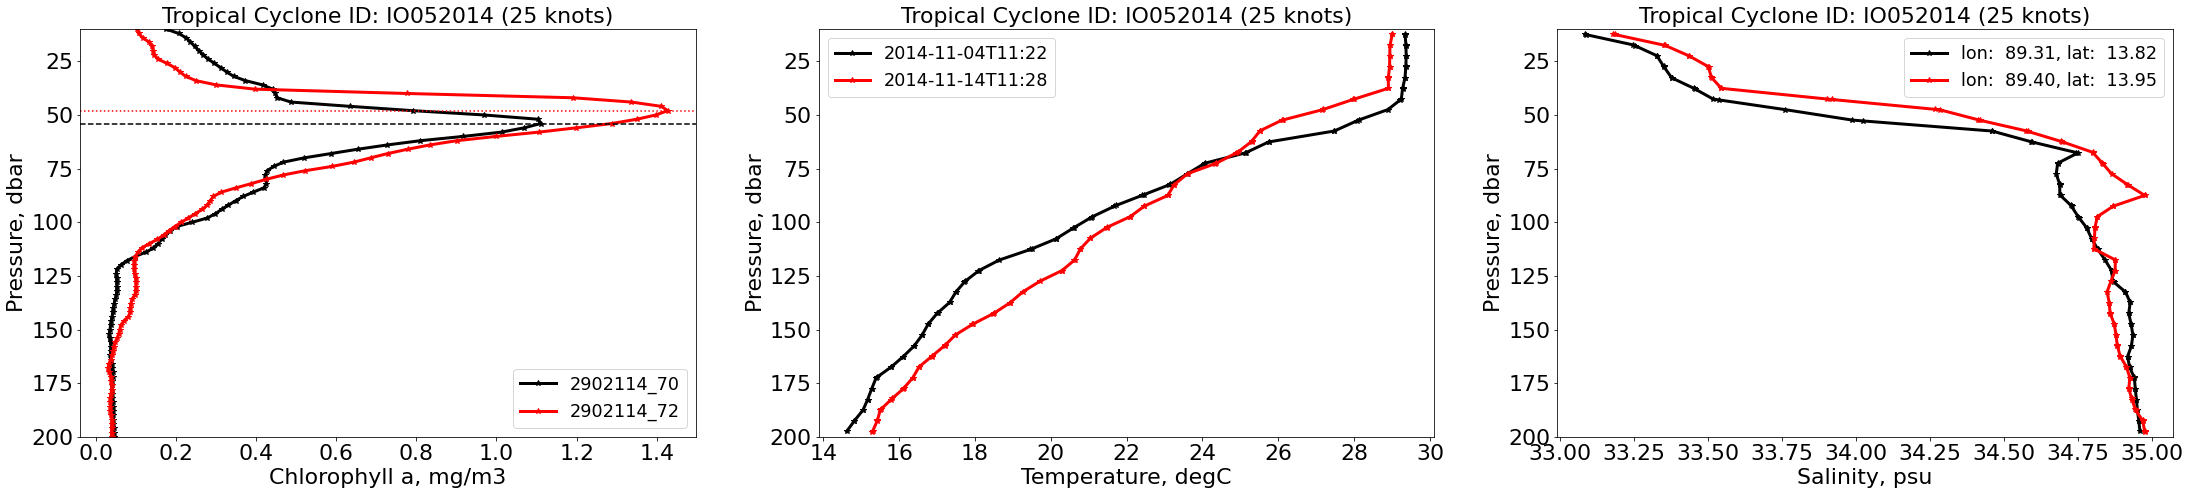

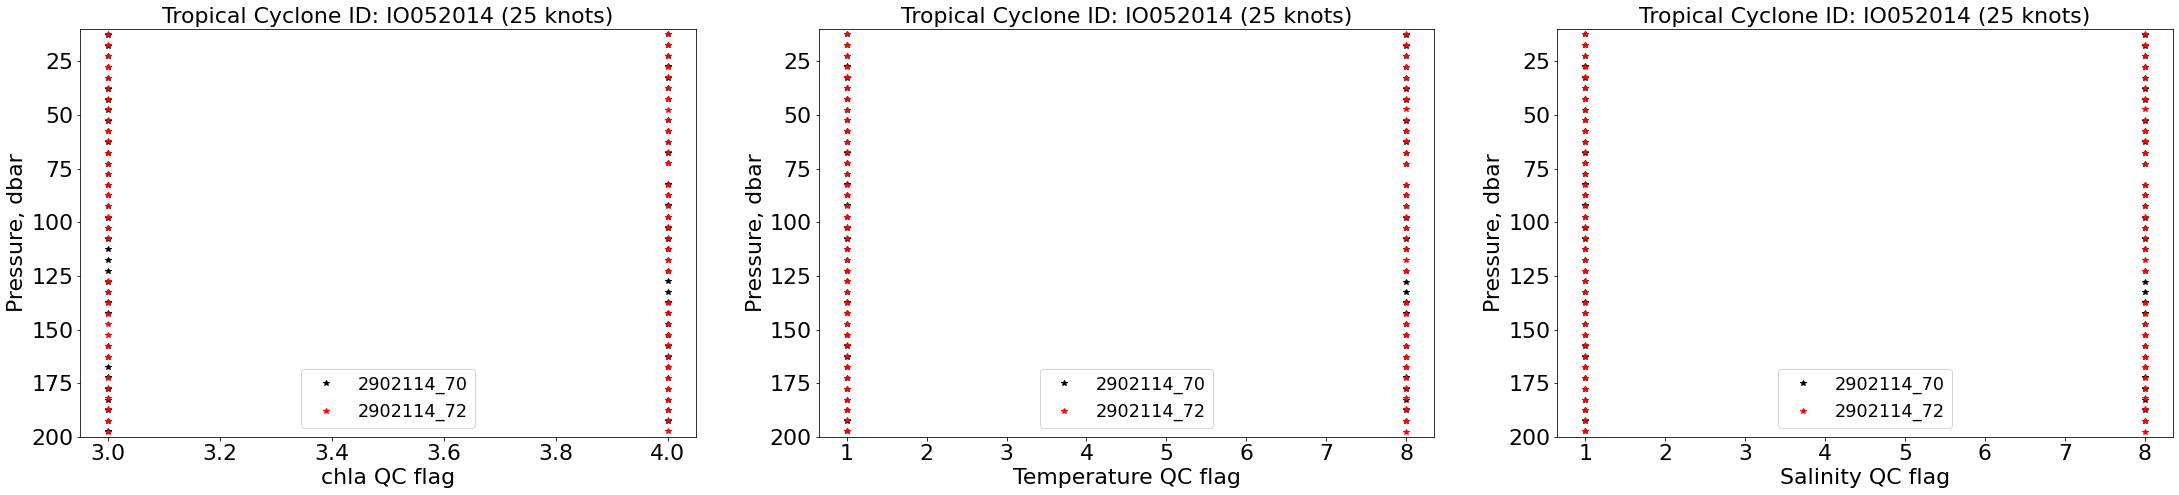

+++++++++++++++ Tropical Cyclone ID: IO052014 +++++++++++++++


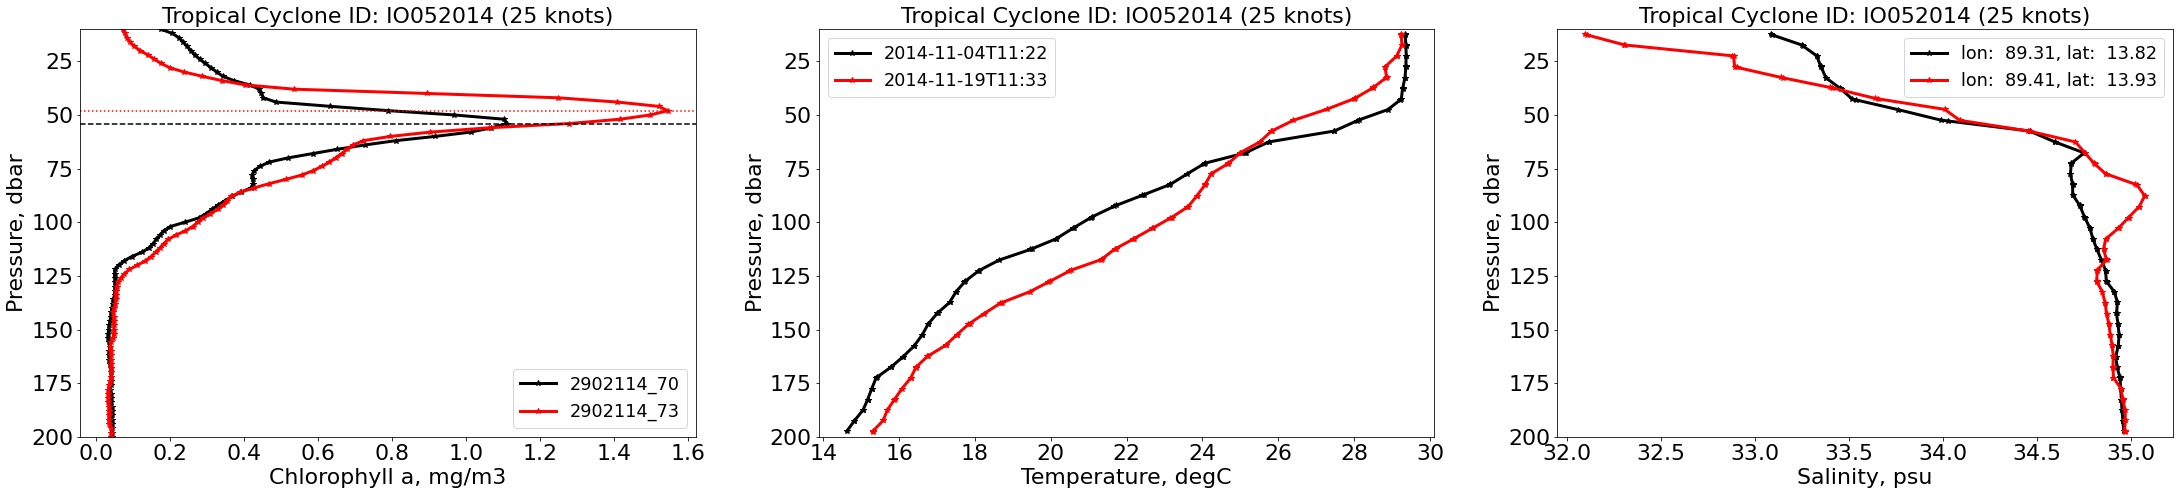

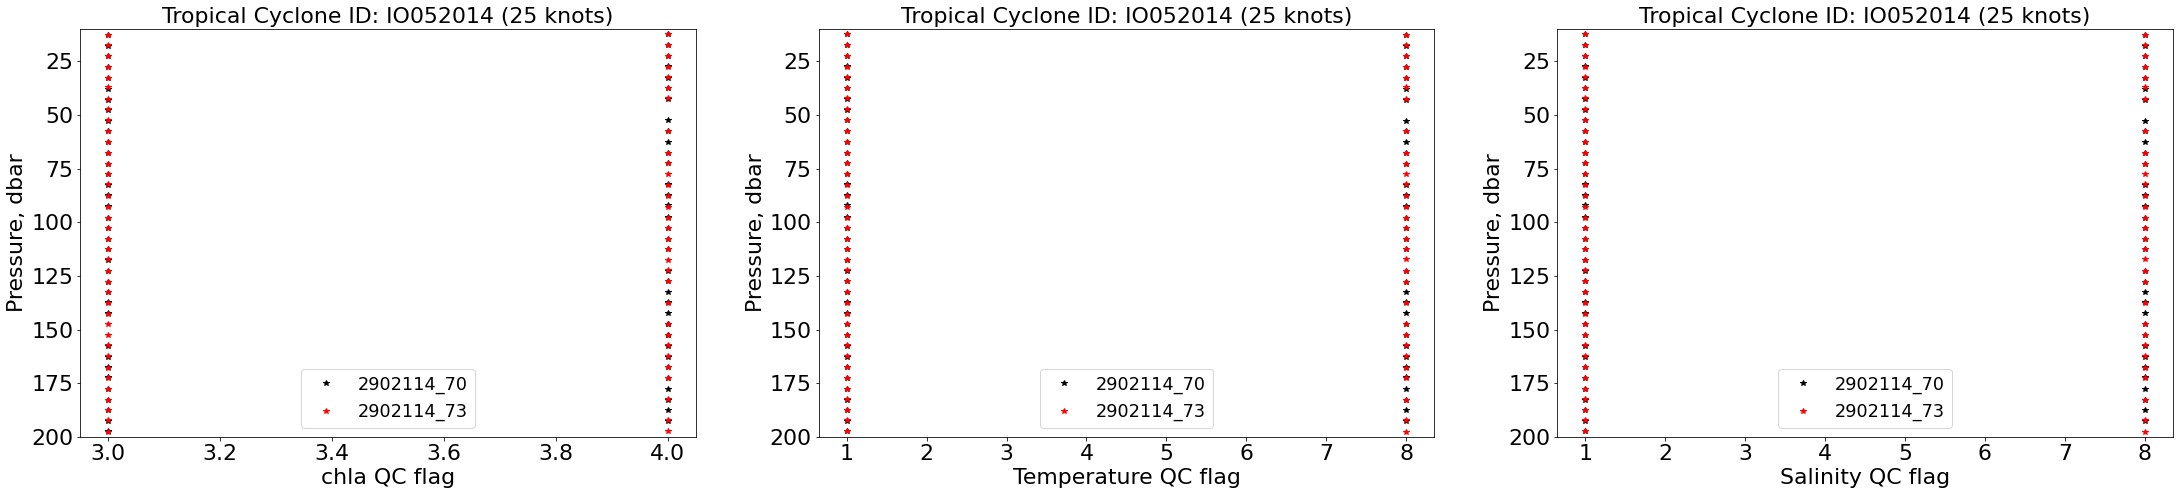

+++++++++++++++ Tropical Cyclone ID: IO052014 +++++++++++++++


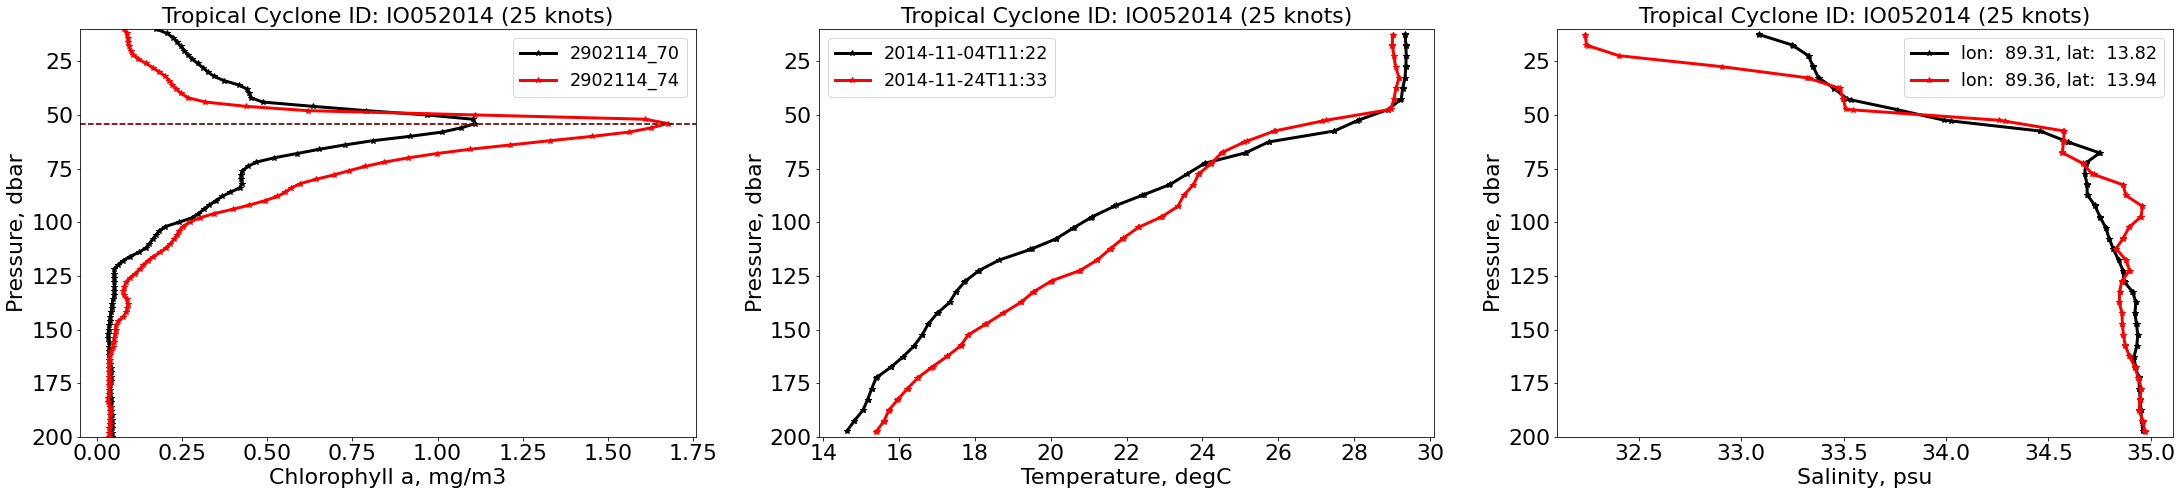

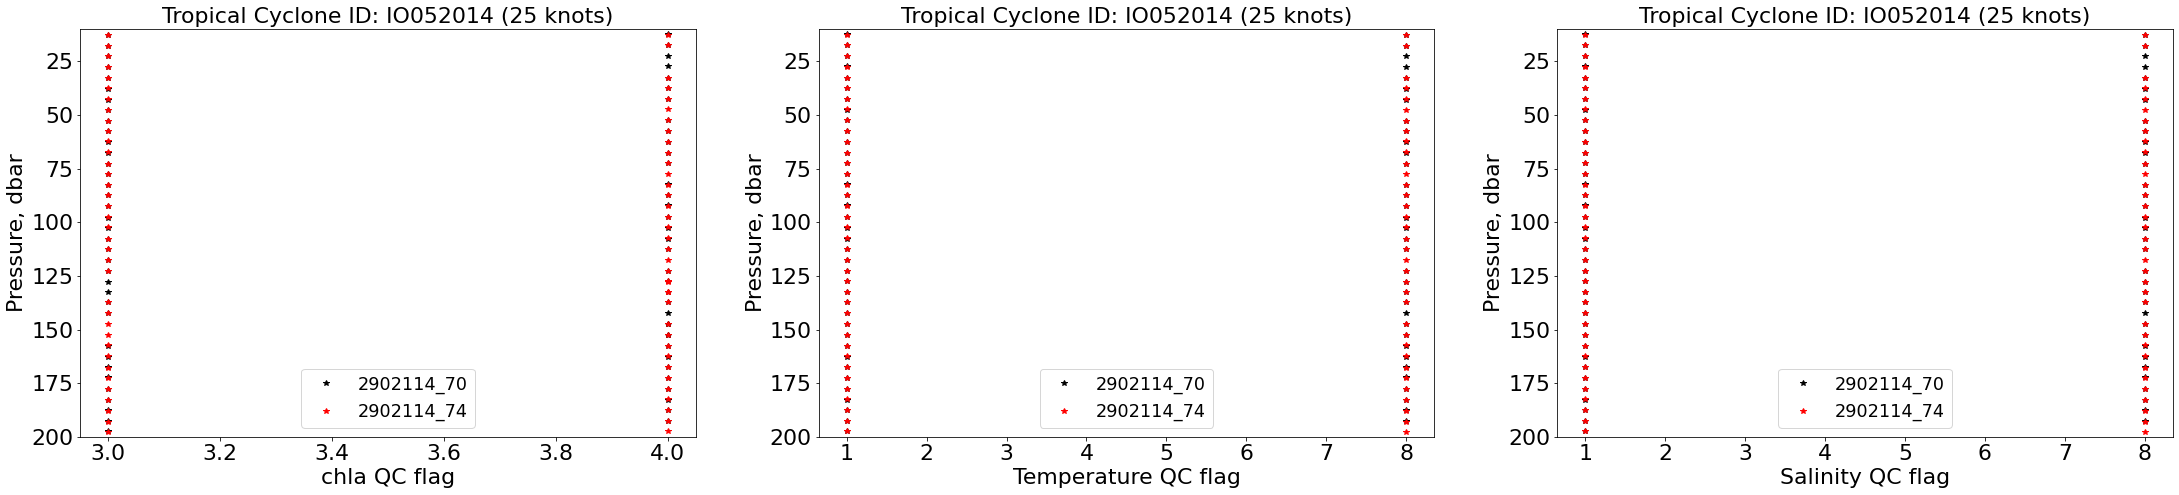

+++++++++++++++ Tropical Cyclone ID: AL042014 +++++++++++++++


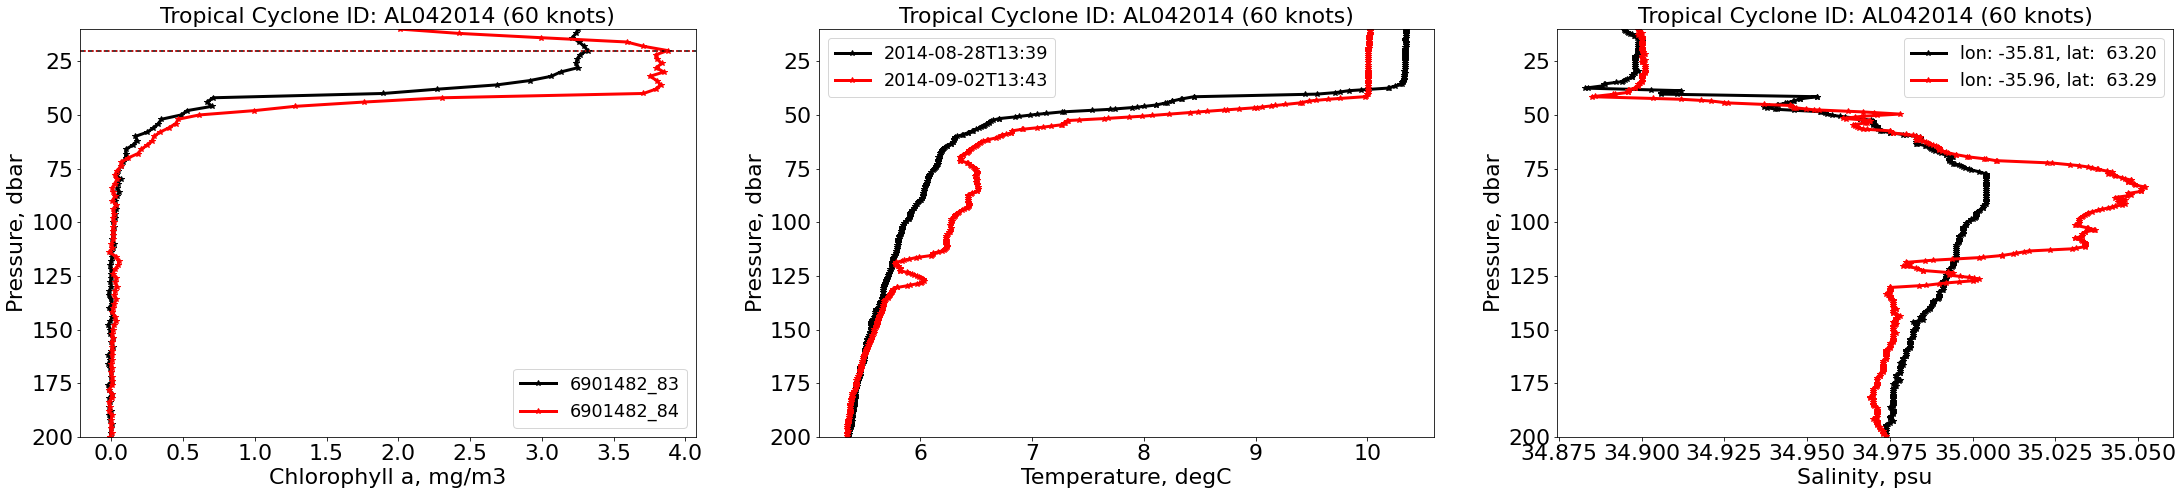

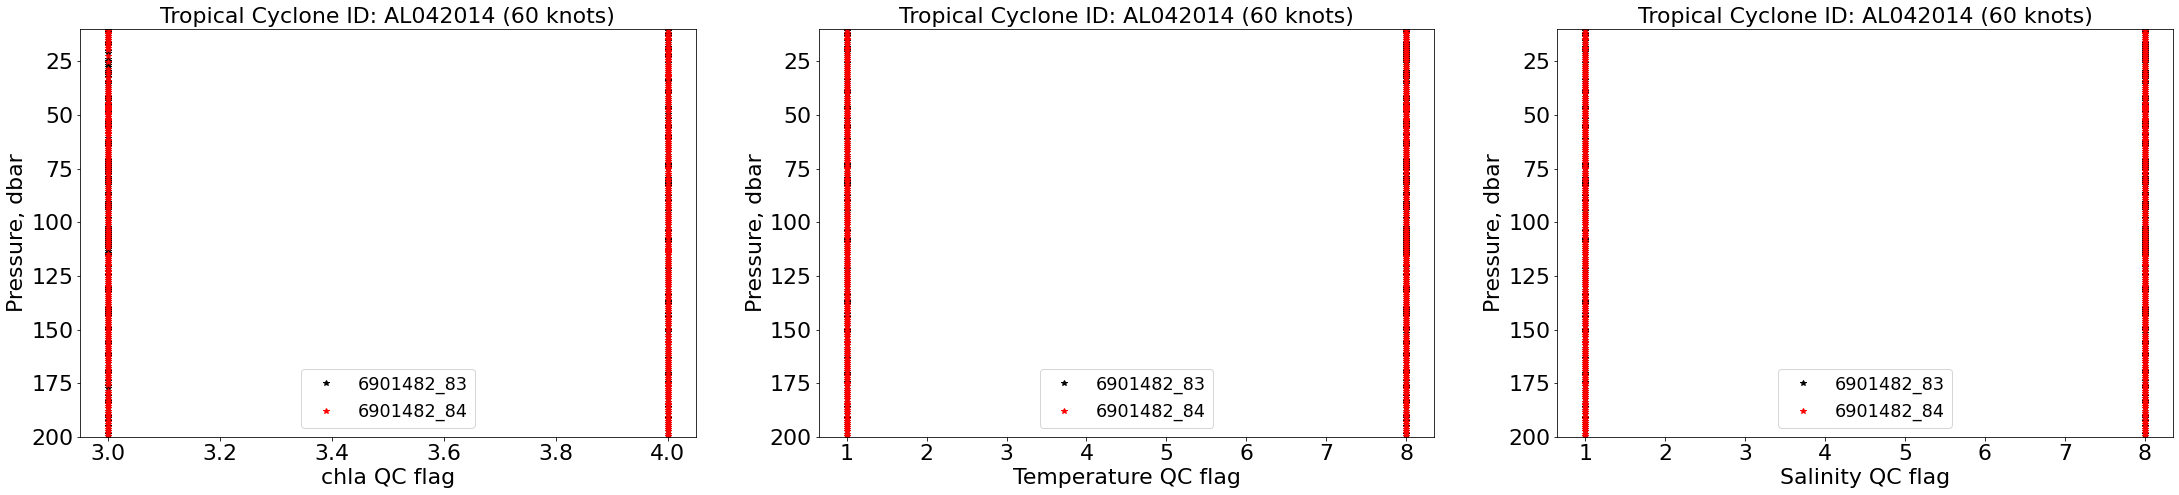

+++++++++++++++ Tropical Cyclone ID: AL012014 +++++++++++++++


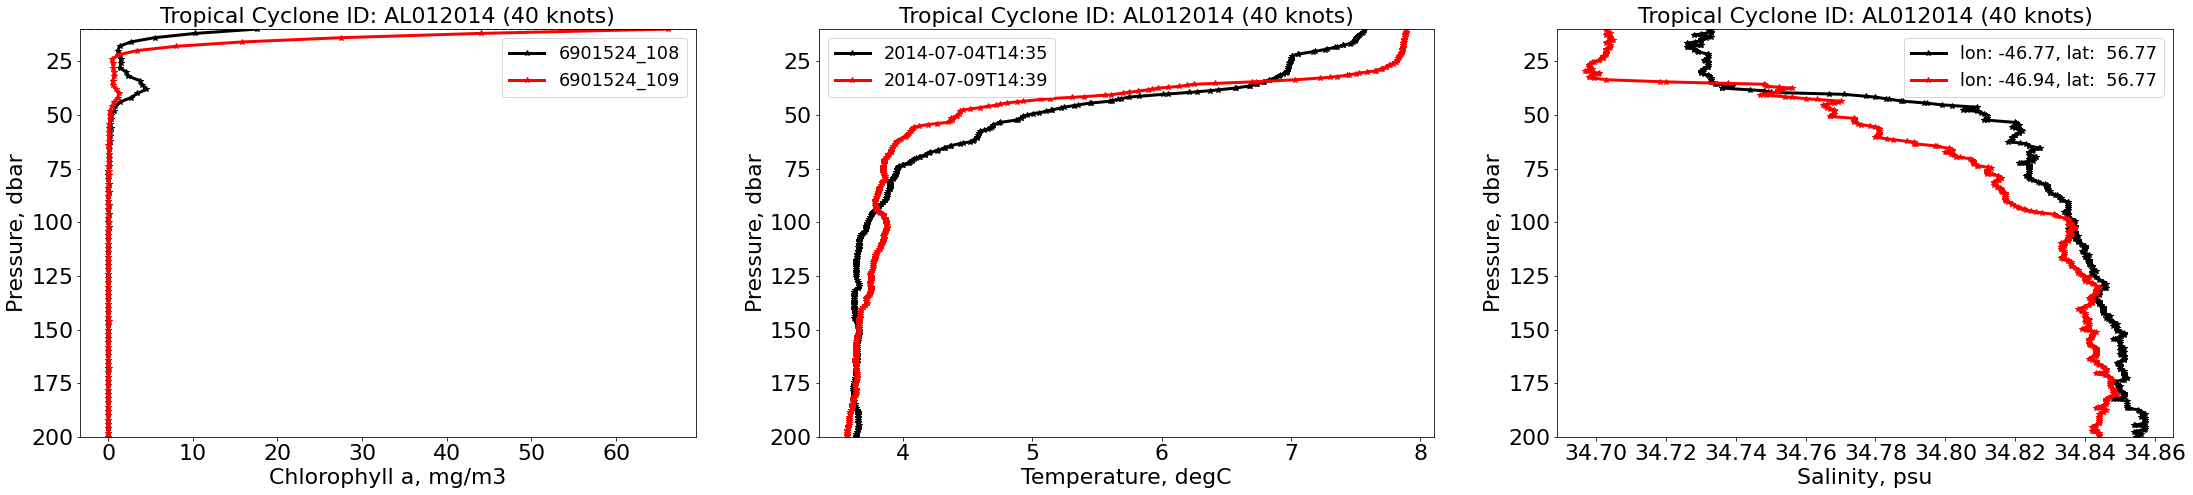

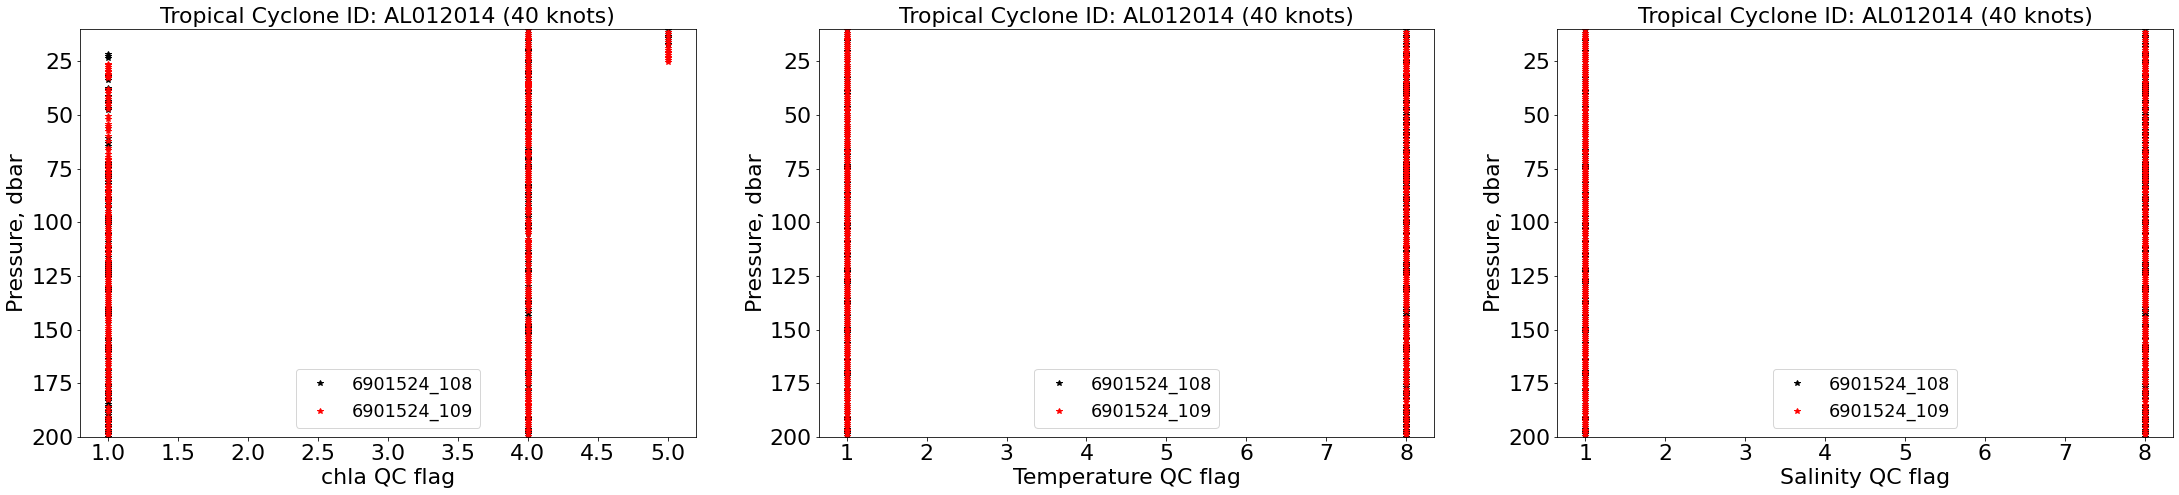

+++++++++++++++ Tropical Cyclone ID: AL012014 +++++++++++++++


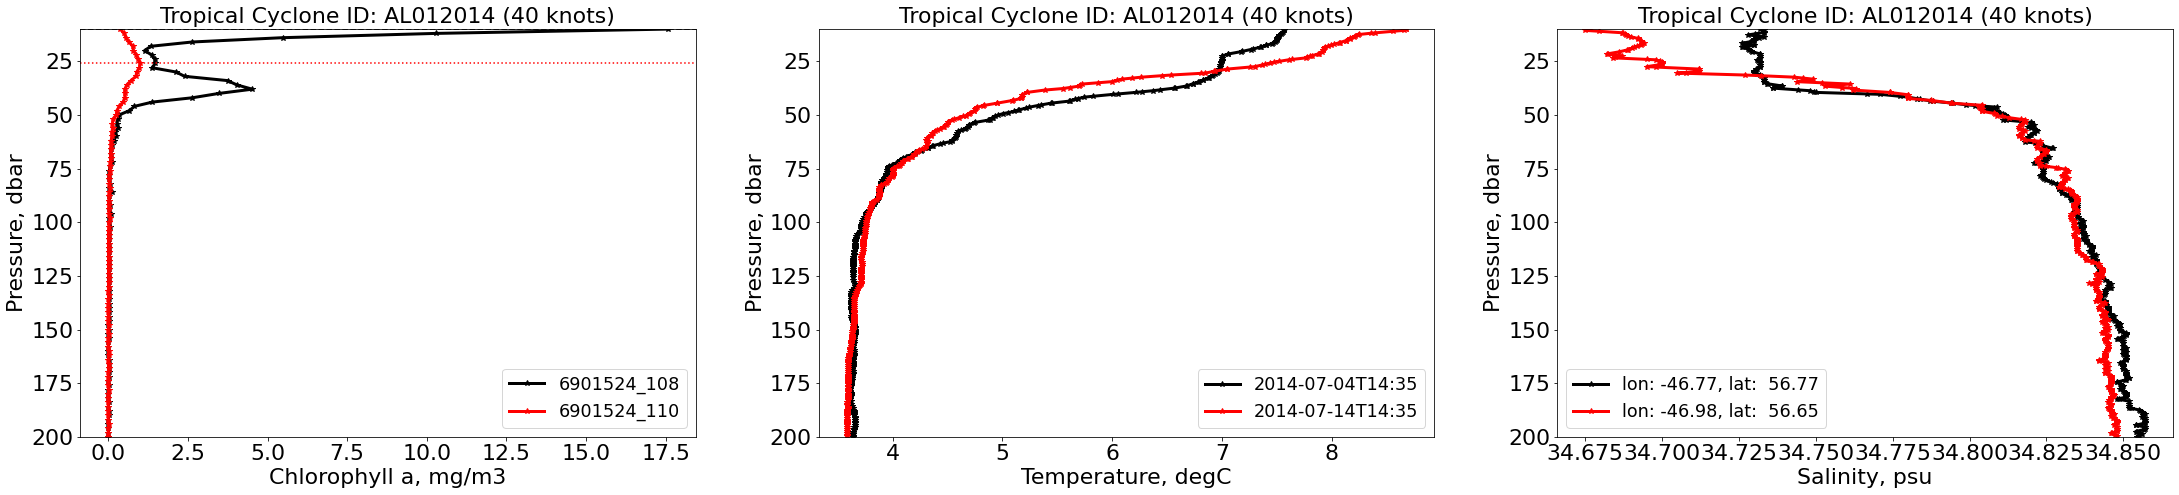

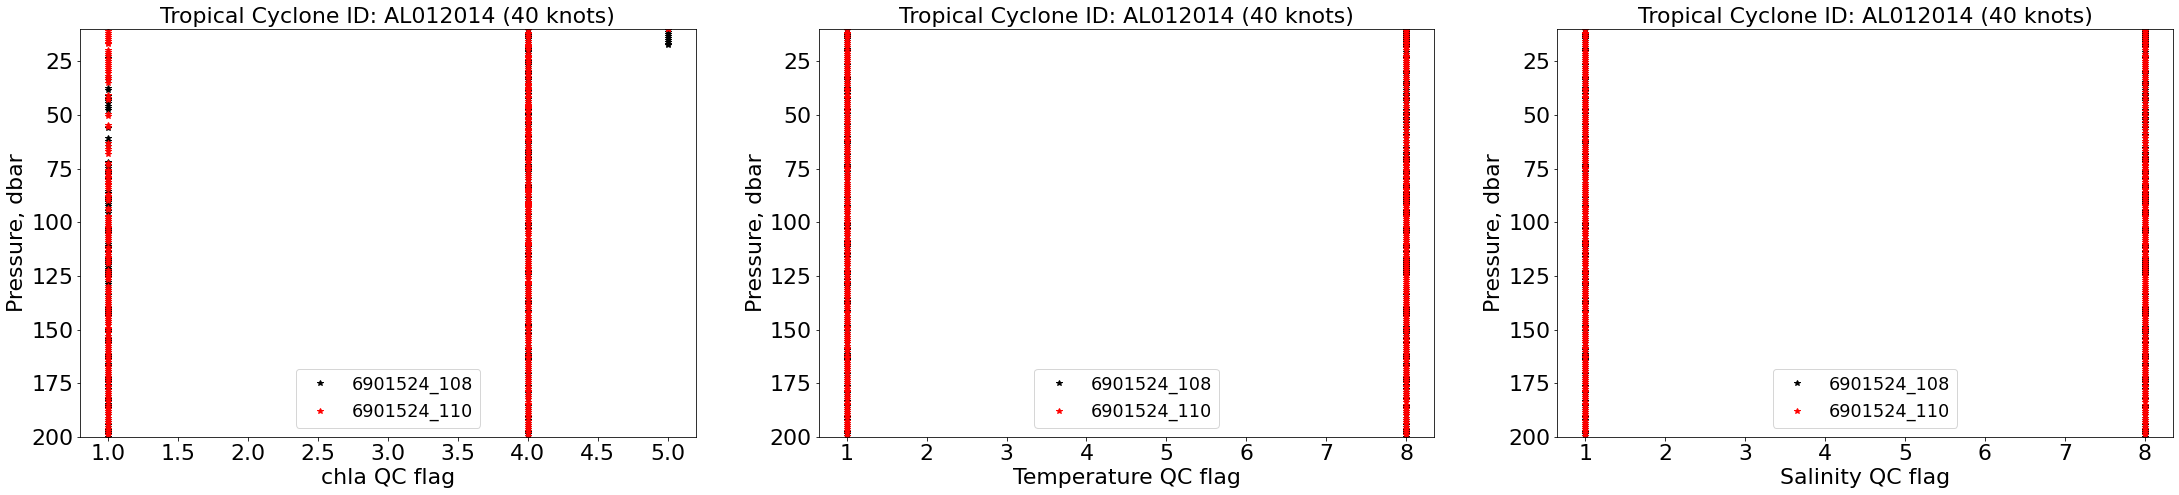

In [10]:
font_size = 22
after_minus_before = []
val_of_max_after   = []
pres_of_max_after  = []
val_of_max_before  = []
pres_of_max_before = []
val_at_shallowest_lev_before = []
val_at_shallowest_lev_after = []
max_val_in_top_10lev_before = []
max_val_in_top_10lev_after  = []

for (b,a,b_pid,a_pid,tcID,tcWind) in zip(raw_before_data,raw_after_data,raw_before_data_pid,raw_after_data_pid,HurricaneID,TC_wind):
    # save wmo and cycle number
    [b_wmo,b_cyln] = b_pid.split("_")
    b_wmo  = b_wmo.lstrip("0")
    b_cyln = b_cyln.lstrip("0")
    [a_wmo,a_cyln] = a_pid.split("_")
    a_wmo  = a_wmo.lstrip("0")
    a_cyln = a_cyln.lstrip("0")
    
    b_TS    = get_profile(b_wmo+'_'+b_cyln)
    a_TS    = get_profile(a_wmo+'_'+a_cyln)
        
#   ####
    if b_TS is not None and a_TS is not None and tcWind>=min_TCwind:
        b_TS_df = parse_1prof_into_df(b_TS,data_type='bgc') 
        a_TS_df = parse_1prof_into_df(a_TS,data_type='bgc') 
        
        print('+++++++++++++++ '+"Tropical Cyclone ID: "+tcID+' +++++++++++++++')
            
#         if var2use+'_qc' in b_TS_df and var2use+'_qc' in a_TS_df:
#             print(b_wmo+'_'+b_cyln+' lon, lat, date')
#             print(set(b_TS_df['lon']))
#             print(set(b_TS_df['lat']))
#             print(set(b_TS_df['date']))
#             print('----------')
#             print(a_wmo+'_'+a_cyln+' lon, lat, date')
#             print(set(a_TS_df['lon']))
#             print(set(a_TS_df['lat']))
#             print(set(a_TS_df['date']))
            
        # make figure
        fig = plt.figure(figsize=(7.5*5,7.5))
        # bgc var
        plt.subplot(131)
        make_plot(b=b,a=a,b_tag=b_wmo+'_'+b_cyln,a_tag=a_wmo+'_'+a_cyln,x_tag=var_lab,b_yax=pres,a_yax=pres,y_tag='Pressure, dbar',y_lim=pres_lim,title_plot="Tropical Cyclone ID: "+tcID+" ("+str(tcWind)+" knots)")

        # save and plot the pressure of the max value
        xl = plt.xlim();
        val_of_max_before.append(b.max())
        pres_of_max_before.append(pres[b.argmax()])
        plt.plot(xl,[pres[b.argmax()],pres[b.argmax()]],color='k',linestyle='--')

        val_of_max_after.append(a.max())
        pres_of_max_after.append(pres[a.argmax()])
        plt.plot(xl,[pres[a.argmax()],pres[a.argmax()]],color='r',linestyle=':')

        plt.xlim(xl)
        # temperature
        plt.subplot(132)
        make_plot(b=b_TS_df['temp'],a=a_TS_df['temp'],b_tag=list(set(b_TS_df['date']))[0][0:16],a_tag=list(set(a_TS_df['date']))[0][0:16],x_tag='Temperature, degC',b_yax=b_TS_df['pres'],a_yax=a_TS_df['pres'],y_tag='Pressure, dbar',y_lim=pres_lim,title_plot="Tropical Cyclone ID: "+tcID+" ("+str(tcWind)+" knots)")
        # salinity
        plt.subplot(133)
        make_plot(b=b_TS_df['psal'],a=a_TS_df['psal'],
                  b_tag="lon: "+"%6.2f" % list(set(b_TS_df['lon']))[0]+", lat: "+"%6.2f" % list(set(b_TS_df['lat']))[0],
                  a_tag="lon: "+"%6.2f" % list(set(a_TS_df['lon']))[0]+", lat: "+"%6.2f" % list(set(a_TS_df['lat']))[0],
                  x_tag='Salinity, psu',
                  b_yax=b_TS_df['pres'],a_yax=a_TS_df['pres'],y_tag='Pressure, dbar',y_lim=pres_lim,title_plot="Tropical Cyclone ID: "+tcID+" ("+str(tcWind)+" knots)")

        plt.show()
        fig.savefig(path_fig+var2use+'_'+tcID+'_b'+b_wmo+'_'+b_cyln+'_a'+a_wmo+'_'+a_cyln+'_meas.png')
    
        # make figure with QC flags
        if var2use+'_qc' in b_TS_df and var2use+'_qc' in a_TS_df:
            fig = plt.figure(figsize=(7.5*5,7.5))
            # bgc var
            plt.subplot(131)
            make_plot(b=b_TS_df[var2use+'_qc'],a=a_TS_df[var2use+'_qc'],b_tag=b_wmo+'_'+b_cyln,a_tag=a_wmo+'_'+a_cyln,x_tag=var2use+' QC flag',b_yax=b_TS_df['pres'],a_yax=a_TS_df['pres'],y_tag='Pressure, dbar',y_lim=pres_lim,title_plot="Tropical Cyclone ID: "+tcID+" ("+str(tcWind)+" knots)")
            # temperature
            plt.subplot(132)
            make_plot(b=b_TS_df['temp_qc'],a=a_TS_df['temp_qc'],b_tag=b_wmo+'_'+b_cyln,a_tag=a_wmo+'_'+a_cyln,x_tag='Temperature QC flag',b_yax=b_TS_df['pres'],a_yax=a_TS_df['pres'],y_tag='Pressure, dbar',y_lim=pres_lim,title_plot="Tropical Cyclone ID: "+tcID+" ("+str(tcWind)+" knots)")
            # salinity
            plt.subplot(133)
            make_plot(b=b_TS_df['psal_qc'],a=a_TS_df['psal_qc'],b_tag=b_wmo+'_'+b_cyln,a_tag=a_wmo+'_'+a_cyln,x_tag='Salinity QC flag',b_yax=b_TS_df['pres'],a_yax=a_TS_df['pres'],y_tag='Pressure, dbar',y_lim=pres_lim,title_plot="Tropical Cyclone ID: "+tcID+" ("+str(tcWind)+" knots)")

            plt.show()
            fig.savefig(path_fig+var2use+'_'+tcID+'_b'+b_wmo+'_'+b_cyln+'_a'+a_wmo+'_'+a_cyln+'_measQC.png')
    # save the after-before difference
    after_minus_before.append([a-b])
    val_at_shallowest_lev_before.append(b[0])
    val_at_shallowest_lev_after.append(a[0])
    max_val_in_top_10lev_before.append(max(b[0:9]))
    max_val_in_top_10lev_after.append(max(a[0:9]))